# Robustness Analysis of Hierarchical Object Detection Models

This notebook analyzes the output of robustness tests to investigate how hierarchical models degrade under various image corruptions.

**Hypothesis:** As image corruption increases, models will gracefully degrade by making more predictions for general ancestor classes rather than specific leaf nodes.

**Methodology:**
1.  **Configure Models:** Specify the paths to the robustness test results for each model to be analyzed.
2.  **Process Raw Data:** The notebook will load the raw prediction `.pkl` files generated by `test_robustness.py`.
3.  **Calculate Hierarchical Statistics:** For each model, corruption, and severity level, it calculates the distribution of predictions (True Positives, Parent, Sibling, False Negatives, etc.).
4.  **Visualize Trends:** Interactive plots are generated to visualize how the prediction distribution changes across corruption severities for different models.

## Project Setup

The following cell adds the project's root directory to the Python path. This is a necessary step to ensure that the notebook can import modules from the `tools` and `hod` directories, as it's located in a subdirectory.

In [1]:
import sys
import os

# Add project root to the Python path
# This allows importing from the 'tools' and 'hod' directories
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)

In [2]:
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mmengine import Config
from mmengine.registry import init_default_scope
from mmengine.utils import ProgressBar
from mmdet.registry import DATASETS
from hod.utils.tree import HierarchyTree
from collections import defaultdict
import warnings

# Suppress specific warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning, message=".*Creating a tensor from a list of numpy.ndarrays is slow.*")

# Initialize the default scope for MMDetection
init_default_scope('mmdet')

## 1. Configuration

**Action Required:** Update the `MODELS_TO_ANALYZE` dictionary below.

- **Keys:** A short, descriptive name for each model that will be used as a label in the plots.
- **Values:** A dictionary containing:
    - `config`: The path to the model's configuration file.
    - `results_path`: The path to the directory containing the raw robustness prediction files (e.g., `outputs/robustness/dino_hier_aircraft/`).

In [3]:
MODELS_TO_ANALYZE = {
    # "DINO-E": {
    #     "config": "configs/hod/models/embedding_dino/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func.py",
    #     "results_path": "outputs/robustness/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func"
    # },
    "DINO": {
        "config": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/robustness/dino-r50_improved_8xb2-36e_aircraft-func"
    },
    "DINO-H (M)": {
        "config": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/robustness/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func"
    },
    "DINO-H (S)": {
        "config": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/robustness/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func-single"
    },
}

## 2. Helper Functions

These functions are adapted from the `hierarchical_prediction_distribution.py` script to process the raw prediction data and calculate the hierarchical statistics.

In [4]:
from tools.analysis_tools.hierarchical_prediction_distribution import (
    calculate_confusion_matrix,
    calculate_hierarchical_prediction_distribution
)

## 3. Data Processing

This section iterates through the configured models and their result files, calculates the statistics for each corruption and severity level, and compiles them into a single DataFrame.

In [5]:
all_stats = []

for model_name, model_info in MODELS_TO_ANALYZE.items():
    print(f"Processing model: {model_name}...")
    
    config_path = model_info['config']
    results_path = Path(model_info['results_path'])
    
    if not results_path.exists():
        print(f"  WARNING: Results path not found, skipping: {results_path}")
        continue
        
    # Load config and build dataset
    cfg = Config.fromfile(config_path)
    dataset = DATASETS.build(cfg.test_dataloader.dataset)
    
    # Find all result files
    result_files = list(results_path.glob('*.pkl'))
    prog_bar = ProgressBar(len(result_files))
    
    for pkl_file in result_files:
        # Extract corruption and severity from filename
        parts = pkl_file.stem.split('_sev')
        if len(parts) != 2:
            continue # Skip files not matching the expected format
            
        corruption = parts[0].replace('_', ' ').title()
        severity = int(parts[1])
        
        # Load results
        with open(pkl_file, 'rb') as f:
            results = pickle.load(f)
            
        # Calculate stats
        confusion_matrix = calculate_confusion_matrix(dataset, results, score_thr=0.3, tp_iou_thr=0.5)
        hierarchical_stats = calculate_hierarchical_prediction_distribution(dataset, confusion_matrix)
        
        # Store the 'Total' stats
        total_stats = hierarchical_stats['Total']
        total_stats['model'] = model_name
        total_stats['corruption'] = corruption
        total_stats['severity'] = severity
        all_stats.append(total_stats)
        prog_bar.update()

# Create DataFrame
df = pd.DataFrame(all_stats)

print("\nProcessing complete.")
if not df.empty:
    print("DataFrame created with the following columns:")
    print(df.columns)
else:
    print("No data was processed. Please check your `MODELS_TO_ANALYZE` configuration.")

Processing model: DINO...
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
[                                                  ] 0/76, elapsed: 0s, ETA:

Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15590.24img/s]

[                                  ] 1/76, 2.2 task/s, elapsed: 0s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15415.25img/s]

[                                  ] 2/76, 2.2 task/s, elapsed: 1s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15345.22img/s]

[>                                 ] 3/76, 1.9 task/s, elapsed: 2s, ETA:    39s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18080.28img/s]

[>                                 ] 4/76, 1.9 task/s, elapsed: 2s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 21766.02img/s]

[>>                                ] 5/76, 1.8 task/s, elapsed: 3s, ETA:    39s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15581.03img/s]

[>>                                ] 6/76, 1.8 task/s, elapsed: 3s, ETA:    38s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15863.16img/s]

[>>>                               ] 7/76, 1.9 task/s, elapsed: 4s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 19634.62img/s]

[>>>                               ] 8/76, 1.8 task/s, elapsed: 4s, ETA:    38s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15915.17img/s]

[>>>>                              ] 9/76, 1.8 task/s, elapsed: 5s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 20617.68img/s]

[>>>>                             ] 10/76, 1.9 task/s, elapsed: 5s, ETA:    35s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 12187.85img/s]

[>>>>                             ] 11/76, 1.8 task/s, elapsed: 6s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16501.27img/s]

[>>>>>                            ] 12/76, 1.8 task/s, elapsed: 7s, ETA:    36s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18731.16img/s]

[>>>>>                            ] 13/76, 1.8 task/s, elapsed: 7s, ETA:    36s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15993.85img/s]

[>>>>>>                           ] 14/76, 1.8 task/s, elapsed: 8s, ETA:    35s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16229.60img/s]

[>>>>>>                           ] 15/76, 1.8 task/s, elapsed: 8s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17776.90img/s]

[>>>>>>                           ] 16/76, 1.8 task/s, elapsed: 9s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17179.44img/s]

[>>>>>>>                          ] 17/76, 1.8 task/s, elapsed: 9s, ETA:    33s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15132.27img/s]

[>>>>>>>                         ] 18/76, 1.8 task/s, elapsed: 10s, ETA:    32s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15312.99img/s]

[>>>>>>>>                        ] 19/76, 1.8 task/s, elapsed: 11s, ETA:    32s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15761.06img/s]

[>>>>>>>>                        ] 20/76, 1.8 task/s, elapsed: 11s, ETA:    31s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18024.00img/s]

[>>>>>>>>                        ] 21/76, 1.8 task/s, elapsed: 12s, ETA:    31s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16253.44img/s]

[>>>>>>>>>                       ] 22/76, 1.8 task/s, elapsed: 12s, ETA:    30s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15542.06img/s]

[>>>>>>>>>                       ] 23/76, 1.8 task/s, elapsed: 13s, ETA:    29s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16188.67img/s]

[>>>>>>>>>>                      ] 24/76, 1.8 task/s, elapsed: 13s, ETA:    29s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17411.45img/s]

[>>>>>>>>>>                      ] 25/76, 1.8 task/s, elapsed: 14s, ETA:    28s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15521.41img/s]

[>>>>>>>>>>                      ] 26/76, 1.8 task/s, elapsed: 14s, ETA:    27s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15794.42img/s]

[>>>>>>>>>>>                     ] 27/76, 1.8 task/s, elapsed: 15s, ETA:    27s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18930.66img/s]

[>>>>>>>>>>>                     ] 28/76, 1.8 task/s, elapsed: 15s, ETA:    26s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 19096.19img/s]

[>>>>>>>>>>>>                    ] 29/76, 1.8 task/s, elapsed: 16s, ETA:    26s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 24041.50img/s]

[>>>>>>>>>>>>                    ] 30/76, 1.8 task/s, elapsed: 17s, ETA:    25s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15742.92img/s]

[>>>>>>>>>>>>>                   ] 31/76, 1.8 task/s, elapsed: 17s, ETA:    25s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16640.70img/s]

[>>>>>>>>>>>>>                   ] 32/76, 1.8 task/s, elapsed: 18s, ETA:    24s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16212.93img/s]

[>>>>>>>>>>>>>                   ] 33/76, 1.8 task/s, elapsed: 18s, ETA:    24s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18875.80img/s]

[>>>>>>>>>>>>>>                  ] 34/76, 1.8 task/s, elapsed: 19s, ETA:    23s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16335.91img/s]

[>>>>>>>>>>>>>>                  ] 35/76, 1.8 task/s, elapsed: 19s, ETA:    23s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17197.99img/s]

[>>>>>>>>>>>>>>>                 ] 36/76, 1.8 task/s, elapsed: 20s, ETA:    22s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15370.23img/s]

[>>>>>>>>>>>>>>>                 ] 37/76, 1.8 task/s, elapsed: 20s, ETA:    21s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15502.54img/s]

[>>>>>>>>>>>>>>>>                ] 38/76, 1.8 task/s, elapsed: 21s, ETA:    21s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16650.54img/s]

[>>>>>>>>>>>>>>>>                ] 39/76, 1.8 task/s, elapsed: 21s, ETA:    20s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15607.58img/s]

[>>>>>>>>>>>>>>>>                ] 40/76, 1.8 task/s, elapsed: 22s, ETA:    20s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15972.03img/s]

[>>>>>>>>>>>>>>>>>               ] 41/76, 1.8 task/s, elapsed: 22s, ETA:    19s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17695.18img/s]

[>>>>>>>>>>>>>>>>>               ] 42/76, 1.8 task/s, elapsed: 23s, ETA:    19s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15417.96img/s]

[>>>>>>>>>>>>>>>>>>              ] 43/76, 1.8 task/s, elapsed: 24s, ETA:    18s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17038.30img/s]

[>>>>>>>>>>>>>>>>>>              ] 44/76, 1.8 task/s, elapsed: 24s, ETA:    17s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16760.39img/s]

[>>>>>>>>>>>>>>>>>>              ] 45/76, 1.8 task/s, elapsed: 25s, ETA:    17s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 21223.58img/s]

[>>>>>>>>>>>>>>>>>>>             ] 46/76, 1.8 task/s, elapsed: 25s, ETA:    16s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16579.95img/s]

[>>>>>>>>>>>>>>>>>>>             ] 47/76, 1.8 task/s, elapsed: 26s, ETA:    16s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 22069.36img/s]

[>>>>>>>>>>>>>>>>>>>>            ] 48/76, 1.8 task/s, elapsed: 26s, ETA:    15s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15862.69img/s]

[>>>>>>>>>>>>>>>>>>>>            ] 49/76, 1.8 task/s, elapsed: 27s, ETA:    15s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15409.43img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 50/76, 1.8 task/s, elapsed: 27s, ETA:    14s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 22074.84img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 51/76, 1.8 task/s, elapsed: 28s, ETA:    14s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16392.80img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 52/76, 1.8 task/s, elapsed: 28s, ETA:    13s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15891.37img/s]

[>>>>>>>>>>>>>>>>>>>>>>          ] 53/76, 1.8 task/s, elapsed: 29s, ETA:    13s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15951.25img/s]

[>>>>>>>>>>>>>>>>>>>>>>          ] 54/76, 1.8 task/s, elapsed: 29s, ETA:    12s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18765.07img/s]

[>>>>>>>>>>>>>>>>>>>>>>>         ] 55/76, 1.8 task/s, elapsed: 30s, ETA:    11s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16114.61img/s]

[>>>>>>>>>>>>>>>>>>>>>>>         ] 56/76, 1.8 task/s, elapsed: 31s, ETA:    11s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16435.66img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 57/76, 1.8 task/s, elapsed: 31s, ETA:    10s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15945.96img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 58/76, 1.8 task/s, elapsed: 32s, ETA:    10s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 19630.79img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 59/76, 1.8 task/s, elapsed: 32s, ETA:     9s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16348.69img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>       ] 60/76, 1.8 task/s, elapsed: 33s, ETA:     9s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15289.62img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>       ] 61/76, 1.8 task/s, elapsed: 33s, ETA:     8s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16419.96img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 62/76, 1.8 task/s, elapsed: 34s, ETA:     8s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18490.76img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 63/76, 1.8 task/s, elapsed: 34s, ETA:     7s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15553.01img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 64/76, 1.8 task/s, elapsed: 35s, ETA:     7s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 19830.75img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 65/76, 1.8 task/s, elapsed: 35s, ETA:     6s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 19740.23img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 66/76, 1.8 task/s, elapsed: 36s, ETA:     5s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 19748.77img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>    ] 67/76, 1.8 task/s, elapsed: 36s, ETA:     5s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17696.27img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>    ] 68/76, 1.9 task/s, elapsed: 37s, ETA:     4s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16219.52img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 69/76, 1.8 task/s, elapsed: 37s, ETA:     4s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 19876.54img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 70/76, 1.9 task/s, elapsed: 38s, ETA:     3s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16701.64img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 71/76, 1.8 task/s, elapsed: 38s, ETA:     3s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15870.85img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  ] 72/76, 1.9 task/s, elapsed: 39s, ETA:     2s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17648.21img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  ] 73/76, 1.9 task/s, elapsed: 39s, ETA:     2s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16873.06img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 74/76, 1.9 task/s, elapsed: 40s, ETA:     1s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17812.52img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 75/76, 1.9 task/s, elapsed: 40s, ETA:     1s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15532.90img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 76/76, 1.8 task/s, elapsed: 41s, ETA:     0s

Processing model: DINO-H (M)...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[                                                  ] 0/76, elapsed: 0s, ETA:

Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10392.61img/s]

[                                  ] 1/76, 1.7 task/s, elapsed: 1s, ETA:    44s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10151.94img/s]

[                                  ] 2/76, 1.7 task/s, elapsed: 1s, ETA:    43s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10475.33img/s]

[>                                 ] 3/76, 1.6 task/s, elapsed: 2s, ETA:    47s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10889.32img/s]

[>                                 ] 4/76, 1.6 task/s, elapsed: 2s, ETA:    45s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11796.85img/s]

[>>                                ] 5/76, 1.6 task/s, elapsed: 3s, ETA:    46s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10300.00img/s]

[>>                                ] 6/76, 1.6 task/s, elapsed: 4s, ETA:    44s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10335.38img/s]

[>>>                               ] 7/76, 1.5 task/s, elapsed: 5s, ETA:    45s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10902.98img/s]

[>>>                               ] 8/76, 1.6 task/s, elapsed: 5s, ETA:    43s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10304.38img/s]

[>>>>                              ] 9/76, 1.6 task/s, elapsed: 6s, ETA:    42s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11625.66img/s]

[>>>>                             ] 10/76, 1.6 task/s, elapsed: 6s, ETA:    42s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10394.97img/s]

[>>>>                             ] 11/76, 1.6 task/s, elapsed: 7s, ETA:    41s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10508.44img/s]

[>>>>>                            ] 12/76, 1.6 task/s, elapsed: 8s, ETA:    41s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11204.14img/s]

[>>>>>                            ] 13/76, 1.6 task/s, elapsed: 8s, ETA:    40s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10306.18img/s]

[>>>>>>                           ] 14/76, 1.6 task/s, elapsed: 9s, ETA:    40s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10430.61img/s]

[>>>>>>                          ] 15/76, 1.6 task/s, elapsed: 10s, ETA:    39s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10226.27img/s]

[>>>>>>                          ] 16/76, 1.6 task/s, elapsed: 10s, ETA:    38s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10906.96img/s]

[>>>>>>>                         ] 17/76, 1.6 task/s, elapsed: 11s, ETA:    38s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10179.38img/s]

[>>>>>>>                         ] 18/76, 1.6 task/s, elapsed: 11s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10375.73img/s]

[>>>>>>>>                        ] 19/76, 1.6 task/s, elapsed: 12s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10190.42img/s]

[>>>>>>>>                        ] 20/76, 1.6 task/s, elapsed: 13s, ETA:    36s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10957.06img/s]

[>>>>>>>>                        ] 21/76, 1.6 task/s, elapsed: 13s, ETA:    35s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10590.50img/s]

[>>>>>>>>>                       ] 22/76, 1.6 task/s, elapsed: 14s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10523.32img/s]

[>>>>>>>>>                       ] 23/76, 1.6 task/s, elapsed: 15s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10124.47img/s]

[>>>>>>>>>>                      ] 24/76, 1.6 task/s, elapsed: 15s, ETA:    33s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10483.59img/s]

[>>>>>>>>>>                      ] 25/76, 1.6 task/s, elapsed: 16s, ETA:    32s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10304.12img/s]

[>>>>>>>>>>                      ] 26/76, 1.6 task/s, elapsed: 17s, ETA:    32s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10449.83img/s]

[>>>>>>>>>>>                     ] 27/76, 1.6 task/s, elapsed: 17s, ETA:    31s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10309.29img/s]

[>>>>>>>>>>>                     ] 28/76, 1.6 task/s, elapsed: 18s, ETA:    30s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11365.94img/s]

[>>>>>>>>>>>>                    ] 29/76, 1.6 task/s, elapsed: 18s, ETA:    30s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11663.88img/s]

[>>>>>>>>>>>>                    ] 30/76, 1.6 task/s, elapsed: 19s, ETA:    29s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10407.18img/s]

[>>>>>>>>>>>>>                   ] 31/76, 1.6 task/s, elapsed: 20s, ETA:    29s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10103.67img/s]

[>>>>>>>>>>>>>                   ] 32/76, 1.6 task/s, elapsed: 20s, ETA:    28s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10548.19img/s]

[>>>>>>>>>>>>>                   ] 33/76, 1.6 task/s, elapsed: 21s, ETA:    27s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10951.05img/s]

[>>>>>>>>>>>>>>                  ] 34/76, 1.6 task/s, elapsed: 22s, ETA:    27s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10630.46img/s]

[>>>>>>>>>>>>>>                  ] 35/76, 1.6 task/s, elapsed: 22s, ETA:    26s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10532.85img/s]

[>>>>>>>>>>>>>>>                 ] 36/76, 1.6 task/s, elapsed: 23s, ETA:    25s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10096.39img/s]

[>>>>>>>>>>>>>>>                 ] 37/76, 1.6 task/s, elapsed: 24s, ETA:    25s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10151.47img/s]

[>>>>>>>>>>>>>>>>                ] 38/76, 1.6 task/s, elapsed: 24s, ETA:    24s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10445.27img/s]

[>>>>>>>>>>>>>>>>                ] 39/76, 1.6 task/s, elapsed: 25s, ETA:    24s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10260.68img/s]

[>>>>>>>>>>>>>>>>                ] 40/76, 1.6 task/s, elapsed: 26s, ETA:    23s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10442.52img/s]

[>>>>>>>>>>>>>>>>>               ] 41/76, 1.6 task/s, elapsed: 26s, ETA:    22s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11067.96img/s]

[>>>>>>>>>>>>>>>>>               ] 42/76, 1.6 task/s, elapsed: 27s, ETA:    22s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10520.10img/s]

[>>>>>>>>>>>>>>>>>>              ] 43/76, 1.6 task/s, elapsed: 27s, ETA:    21s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10456.99img/s]

[>>>>>>>>>>>>>>>>>>              ] 44/76, 1.6 task/s, elapsed: 28s, ETA:    20s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10485.92img/s]

[>>>>>>>>>>>>>>>>>>              ] 45/76, 1.6 task/s, elapsed: 29s, ETA:    20s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11522.23img/s]

[>>>>>>>>>>>>>>>>>>>             ] 46/76, 1.6 task/s, elapsed: 29s, ETA:    19s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10647.70img/s]

[>>>>>>>>>>>>>>>>>>>             ] 47/76, 1.6 task/s, elapsed: 30s, ETA:    19s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11106.57img/s]

[>>>>>>>>>>>>>>>>>>>>            ] 48/76, 1.6 task/s, elapsed: 31s, ETA:    18s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10465.42img/s]

[>>>>>>>>>>>>>>>>>>>>            ] 49/76, 1.6 task/s, elapsed: 31s, ETA:    17s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10268.98img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 50/76, 1.6 task/s, elapsed: 32s, ETA:    17s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 12582.09img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 51/76, 1.6 task/s, elapsed: 32s, ETA:    16s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10460.11img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 52/76, 1.6 task/s, elapsed: 33s, ETA:    15s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10595.11img/s]

[>>>>>>>>>>>>>>>>>>>>>>          ] 53/76, 1.6 task/s, elapsed: 34s, ETA:    15s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10322.20img/s]

[>>>>>>>>>>>>>>>>>>>>>>          ] 54/76, 1.6 task/s, elapsed: 34s, ETA:    14s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10581.61img/s]

[>>>>>>>>>>>>>>>>>>>>>>>         ] 55/76, 1.6 task/s, elapsed: 35s, ETA:    13s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10344.71img/s]

[>>>>>>>>>>>>>>>>>>>>>>>         ] 56/76, 1.6 task/s, elapsed: 36s, ETA:    13s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10386.67img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 57/76, 1.6 task/s, elapsed: 36s, ETA:    12s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10444.43img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 58/76, 1.6 task/s, elapsed: 37s, ETA:    11s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11547.68img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 59/76, 1.6 task/s, elapsed: 38s, ETA:    11s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10446.98img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>       ] 60/76, 1.6 task/s, elapsed: 38s, ETA:    10s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10492.99img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>       ] 61/76, 1.6 task/s, elapsed: 39s, ETA:    10s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10190.89img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 62/76, 1.6 task/s, elapsed: 39s, ETA:     9s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11005.86img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 63/76, 1.6 task/s, elapsed: 40s, ETA:     8s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10270.36img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 64/76, 1.6 task/s, elapsed: 41s, ETA:     8s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11097.74img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 65/76, 1.6 task/s, elapsed: 41s, ETA:     7s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11250.26img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 66/76, 1.6 task/s, elapsed: 42s, ETA:     6s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10936.57img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>    ] 67/76, 1.6 task/s, elapsed: 43s, ETA:     6s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10859.27img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>    ] 68/76, 1.6 task/s, elapsed: 43s, ETA:     5s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 9063.63img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 69/76, 1.6 task/s, elapsed: 44s, ETA:     4s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11120.21img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 70/76, 1.6 task/s, elapsed: 45s, ETA:     4s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10270.59img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 71/76, 1.6 task/s, elapsed: 45s, ETA:     3s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10329.74img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  ] 72/76, 1.6 task/s, elapsed: 46s, ETA:     3s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10702.33img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  ] 73/76, 1.6 task/s, elapsed: 47s, ETA:     2s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10264.34img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 74/76, 1.6 task/s, elapsed: 47s, ETA:     1s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 11036.23img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 75/76, 1.6 task/s, elapsed: 48s, ETA:     1s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10182.66img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 76/76, 1.6 task/s, elapsed: 48s, ETA:     0s

Processing model: DINO-H (S)...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[                                                  ] 0/76, elapsed: 0s, ETA:

Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15378.28img/s]

[                                  ] 1/76, 1.9 task/s, elapsed: 1s, ETA:    40s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15306.77img/s]

[                                  ] 2/76, 1.9 task/s, elapsed: 1s, ETA:    39s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15126.80img/s]

[>                                 ] 3/76, 1.7 task/s, elapsed: 2s, ETA:    43s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16115.19img/s]

[>                                 ] 4/76, 1.7 task/s, elapsed: 2s, ETA:    41s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17189.17img/s]

[>>                                ] 5/76, 1.7 task/s, elapsed: 3s, ETA:    42s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15170.73img/s]

[>>                                ] 6/76, 1.7 task/s, elapsed: 4s, ETA:    41s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15416.08img/s]

[>>>                               ] 7/76, 1.7 task/s, elapsed: 4s, ETA:    42s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15962.59img/s]

[>>>                               ] 8/76, 1.7 task/s, elapsed: 5s, ETA:    40s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15214.93img/s]

[>>>>                              ] 9/76, 1.7 task/s, elapsed: 5s, ETA:    40s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17344.01img/s]

[>>>>                             ] 10/76, 1.7 task/s, elapsed: 6s, ETA:    40s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15178.20img/s]

[>>>>                             ] 11/76, 1.7 task/s, elapsed: 7s, ETA:    39s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15541.66img/s]

[>>>>>                            ] 12/76, 1.6 task/s, elapsed: 7s, ETA:    39s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16619.47img/s]

[>>>>>                            ] 13/76, 1.7 task/s, elapsed: 8s, ETA:    38s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15435.66img/s]

[>>>>>>                           ] 14/76, 1.7 task/s, elapsed: 8s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15341.14img/s]

[>>>>>>                           ] 15/76, 1.7 task/s, elapsed: 9s, ETA:    37s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15924.27img/s]

[>>>>>>                          ] 16/76, 1.7 task/s, elapsed: 10s, ETA:    36s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15958.51img/s]

[>>>>>>>                         ] 17/76, 1.7 task/s, elapsed: 10s, ETA:    36s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15262.30img/s]

[>>>>>>>                         ] 18/76, 1.7 task/s, elapsed: 11s, ETA:    35s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15297.59img/s]

[>>>>>>>>                        ] 19/76, 1.7 task/s, elapsed: 11s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15349.77img/s]

[>>>>>>>>                        ] 20/76, 1.7 task/s, elapsed: 12s, ETA:    34s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16238.96img/s]

[>>>>>>>>                        ] 21/76, 1.7 task/s, elapsed: 13s, ETA:    33s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15824.98img/s]

[>>>>>>>>>                       ] 22/76, 1.7 task/s, elapsed: 13s, ETA:    32s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15349.64img/s]

[>>>>>>>>>                       ] 23/76, 1.7 task/s, elapsed: 14s, ETA:    32s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15406.28img/s]

[>>>>>>>>>>                      ] 24/76, 1.7 task/s, elapsed: 14s, ETA:    31s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15880.87img/s]

[>>>>>>>>>>                      ] 25/76, 1.7 task/s, elapsed: 15s, ETA:    30s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15286.05img/s]

[>>>>>>>>>>                      ] 26/76, 1.7 task/s, elapsed: 16s, ETA:    30s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15333.95img/s]

[>>>>>>>>>>>                     ] 27/76, 1.7 task/s, elapsed: 16s, ETA:    29s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16049.00img/s]

[>>>>>>>>>>>                     ] 28/76, 1.7 task/s, elapsed: 17s, ETA:    29s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16583.64img/s]

[>>>>>>>>>>>>                    ] 29/76, 1.7 task/s, elapsed: 17s, ETA:    28s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17491.97img/s]

[>>>>>>>>>>>>                    ] 30/76, 1.7 task/s, elapsed: 18s, ETA:    27s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15261.87img/s]

[>>>>>>>>>>>>>                   ] 31/76, 1.7 task/s, elapsed: 19s, ETA:    27s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15508.29img/s]

[>>>>>>>>>>>>>                   ] 32/76, 1.7 task/s, elapsed: 19s, ETA:    26s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15723.46img/s]

[>>>>>>>>>>>>>                   ] 33/76, 1.7 task/s, elapsed: 20s, ETA:    26s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16522.05img/s]

[>>>>>>>>>>>>>>                  ] 34/76, 1.7 task/s, elapsed: 20s, ETA:    25s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15676.54img/s]

[>>>>>>>>>>>>>>                  ] 35/76, 1.7 task/s, elapsed: 21s, ETA:    24s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15723.51img/s]

[>>>>>>>>>>>>>>>                 ] 36/76, 1.7 task/s, elapsed: 22s, ETA:    24s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15336.20img/s]

[>>>>>>>>>>>>>>>                 ] 37/76, 1.7 task/s, elapsed: 22s, ETA:    23s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15266.93img/s]

[>>>>>>>>>>>>>>>>                ] 38/76, 1.7 task/s, elapsed: 23s, ETA:    23s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15681.66img/s]

[>>>>>>>>>>>>>>>>                ] 39/76, 1.7 task/s, elapsed: 23s, ETA:    22s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15491.66img/s]

[>>>>>>>>>>>>>>>>                ] 40/76, 1.7 task/s, elapsed: 24s, ETA:    21s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15339.45img/s]

[>>>>>>>>>>>>>>>>>               ] 41/76, 1.7 task/s, elapsed: 25s, ETA:    21s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16467.60img/s]

[>>>>>>>>>>>>>>>>>               ] 42/76, 1.7 task/s, elapsed: 25s, ETA:    20s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15247.13img/s]

[>>>>>>>>>>>>>>>>>>              ] 43/76, 1.7 task/s, elapsed: 26s, ETA:    20s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15677.04img/s]

[>>>>>>>>>>>>>>>>>>              ] 44/76, 1.7 task/s, elapsed: 26s, ETA:    19s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15666.14img/s]

[>>>>>>>>>>>>>>>>>>              ] 45/76, 1.7 task/s, elapsed: 27s, ETA:    18s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 17199.62img/s]

[>>>>>>>>>>>>>>>>>>>             ] 46/76, 1.7 task/s, elapsed: 27s, ETA:    18s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15700.92img/s]

[>>>>>>>>>>>>>>>>>>>             ] 47/76, 1.7 task/s, elapsed: 28s, ETA:    17s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16678.20img/s]

[>>>>>>>>>>>>>>>>>>>>            ] 48/76, 1.7 task/s, elapsed: 29s, ETA:    17s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15489.67img/s]

[>>>>>>>>>>>>>>>>>>>>            ] 49/76, 1.7 task/s, elapsed: 29s, ETA:    16s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15081.69img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 50/76, 1.7 task/s, elapsed: 30s, ETA:    16s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 18050.06img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 51/76, 1.7 task/s, elapsed: 30s, ETA:    15s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15816.27img/s]

[>>>>>>>>>>>>>>>>>>>>>           ] 52/76, 1.7 task/s, elapsed: 31s, ETA:    14s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15409.91img/s]

[>>>>>>>>>>>>>>>>>>>>>>          ] 53/76, 1.7 task/s, elapsed: 32s, ETA:    14s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15304.75img/s]

[>>>>>>>>>>>>>>>>>>>>>>          ] 54/76, 1.7 task/s, elapsed: 32s, ETA:    13s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15815.35img/s]

[>>>>>>>>>>>>>>>>>>>>>>>         ] 55/76, 1.7 task/s, elapsed: 33s, ETA:    13s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15543.44img/s]

[>>>>>>>>>>>>>>>>>>>>>>>         ] 56/76, 1.7 task/s, elapsed: 33s, ETA:    12s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15396.41img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 57/76, 1.7 task/s, elapsed: 34s, ETA:    11s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15480.58img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 58/76, 1.7 task/s, elapsed: 35s, ETA:    11s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16527.53img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>        ] 59/76, 1.7 task/s, elapsed: 35s, ETA:    10s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15580.98img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>       ] 60/76, 1.7 task/s, elapsed: 36s, ETA:    10s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 13553.00img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>       ] 61/76, 1.7 task/s, elapsed: 36s, ETA:     9s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15458.33img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 62/76, 1.7 task/s, elapsed: 37s, ETA:     8s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16501.22img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 63/76, 1.7 task/s, elapsed: 38s, ETA:     8s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 14719.09img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>      ] 64/76, 1.7 task/s, elapsed: 38s, ETA:     7s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16742.93img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 65/76, 1.7 task/s, elapsed: 39s, ETA:     7s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16967.36img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 66/76, 1.7 task/s, elapsed: 39s, ETA:     6s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16357.26img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>    ] 67/76, 1.7 task/s, elapsed: 40s, ETA:     5s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16227.27img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>    ] 68/76, 1.7 task/s, elapsed: 41s, ETA:     5s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15508.91img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 69/76, 1.7 task/s, elapsed: 41s, ETA:     4s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16841.77img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 70/76, 1.7 task/s, elapsed: 42s, ETA:     4s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15569.10img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   ] 71/76, 1.7 task/s, elapsed: 43s, ETA:     3s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15324.87img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  ] 72/76, 1.7 task/s, elapsed: 43s, ETA:     2s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15990.18img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  ] 73/76, 1.7 task/s, elapsed: 44s, ETA:     2s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15627.29img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 74/76, 1.7 task/s, elapsed: 44s, ETA:     1s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 16431.83img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 75/76, 1.7 task/s, elapsed: 45s, ETA:     1s


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15262.94img/s]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 76/76, 1.7 task/s, elapsed: 45s, ETA:     0s
Processing complete.
DataFrame created with the following columns:
Index(['total_gt', 'tp', 'parent_tp', 'grandparent_tp', 'sibling_tp',
       'cousin_tp', 'ancestor_tp', 'distance', 'fn', 'fp_bg', 'tp_percentage',
       'parent_percentage', 'grandparent_percentage', 'sibling_percentage',
       'cousin_percentage', 'ancestor_percentage', 'fn_percentage',
       'other_class_percentage', 'avg_distance', 'other_class', 'model',
       'corruption', 'severity'],
      dtype='object')


## 4. Visualization: A Three-Part Story

To clearly demonstrate the robustness of the hierarchical model, we'll analyze the results in three stages:

1.  **Aggregate Analysis:** A high-level view averaging performance across all 15 corruptions to show the overall trend. This plot will give us a general sense of how each model behaves under stress.
2.  **Spotlight Analysis:** A focused look at a few realistic, hand-picked corruptions (e.g., 'Fog', 'Motion Blur'). This provides specific evidence of the hierarchical model's graceful degradation in common scenarios.
3.  **Comprehensive Analysis:** The full, detailed breakdown for every corruption type, allowing for a deep dive into the performance on any specific benchmark.

This approach will build a clear and compelling narrative, starting with a broad overview and progressively zooming in on the details.

### Part 1: Aggregate Analysis (Average Across All Corruptions)

This first plot shows the prediction distribution for each model, averaged across all 15 benchmark corruptions. It provides a clear, high-level summary of how each model's predictions shift as corruption severity increases. We expect to see the hierarchical model trade "Correct as Leaf" predictions for "Predicted as Parent" or other ancestor classes, while the flat model shifts more heavily into "Missed (FN)" or "Other Misclassification."

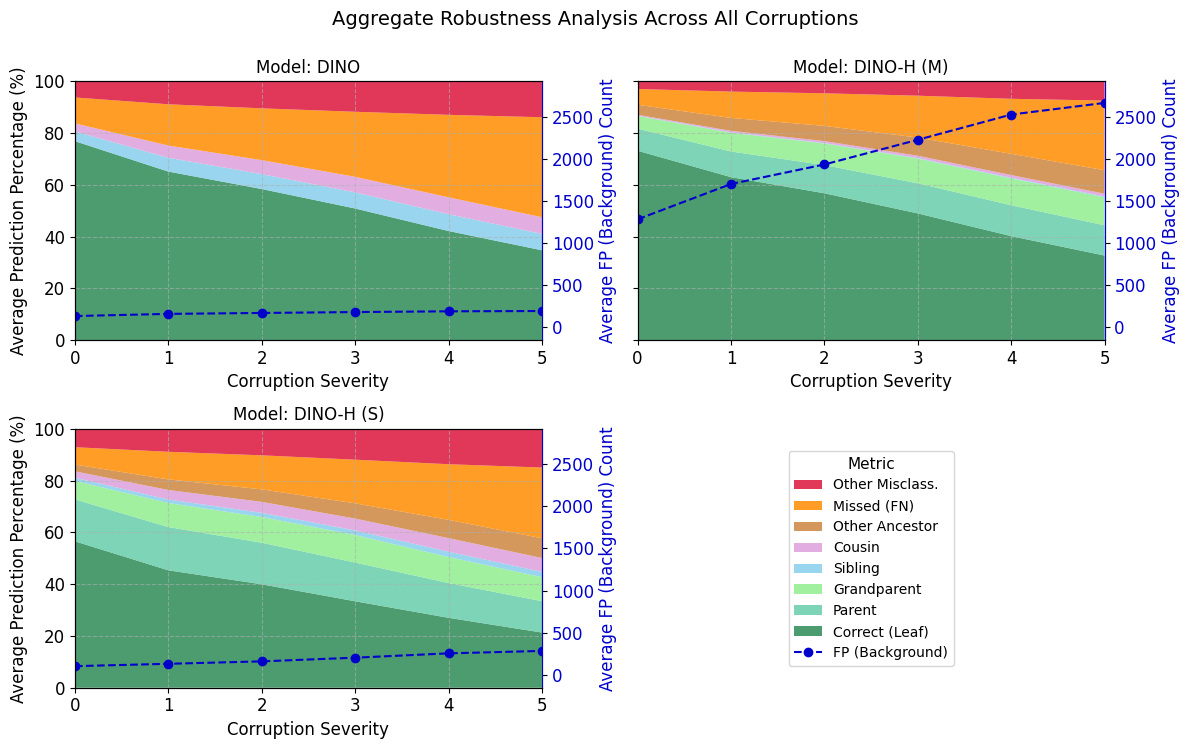

In [22]:
if not df.empty:
    # Define the order, labels, and colors for plotting to be consistent with the analysis script.
    plot_order = [
        'tp_percentage', 
        'parent_percentage', 
        'grandparent_percentage', 
        'sibling_percentage', 
        'cousin_percentage', 
        'ancestor_percentage', 
        'fn_percentage', 
        'other_class_percentage'
    ]
    
    plot_labels = {
        'tp_percentage': 'Correct (Leaf)',
        'parent_percentage': 'Parent',
        'grandparent_percentage': 'Grandparent',
        'sibling_percentage': 'Sibling',
        'cousin_percentage': 'Cousin',
        'ancestor_percentage': 'Other Ancestor',
        'fn_percentage': 'Missed (FN)',
        'other_class_percentage': 'Other Misclass.',
        'fp_bg': 'FP (Background)'
    }

    plot_colors = {
        'tp_percentage': '#2E8B57',
        'parent_percentage': '#66CDAA',
        'grandparent_percentage': '#90EE90',
        'sibling_percentage': '#87CEEB',
        'cousin_percentage': '#DDA0DD',
        'ancestor_percentage': '#CD853F',
        'fn_percentage': '#FF8C00',
        'other_class_percentage': '#DC143C',
        'fp_bg': '#0000CD'
    }

    # Filter out any metrics that are not present in the DataFrame
    available_metrics = [metric for metric in plot_order if metric in df.columns]
    
    # Calculate the average across all corruptions, including fp_bg
    metrics_to_agg = available_metrics + ['fp_bg']
    aggregate_df = df.groupby(['model', 'severity'])[metrics_to_agg].mean().reset_index()

    # Determine the global y-axis limits for the FP count
    fp_min = aggregate_df['fp_bg'].min()
    fp_max = aggregate_df['fp_bg'].max()
    fp_padding = (fp_max - fp_min) * 0.1 if fp_max > fp_min else 1.0
    fp_ylim = (fp_min - fp_padding, fp_max + fp_padding)

    # --- Create a stacked area plot for each model ---
    model_names = aggregate_df['model'].unique()
    num_models = len(model_names)
    ncols = 2 if num_models > 1 else 1
    nrows = int(np.ceil(num_models / ncols))
    total_slots = nrows * ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharey=True)
    axes = np.array(axes).reshape(-1)  # Flatten in case of single row/col

    # Improved suptitle: lower and centered
    fig.suptitle('Aggregate Robustness Analysis Across All Corruptions', fontsize=14, y=0.93)

    right_axes = []
    for i, model_name in enumerate(model_names):
        ax = axes[i]
        model_df = aggregate_df[aggregate_df['model'] == model_name].sort_values('severity')
        
        if model_df.empty:
            ax.set_title(f'{model_name}\n(No Data)', fontsize=12)
            ax.set_visible(False)
            right_axes.append(None)
            continue

        x = model_df['severity'].values
        y_arrays = [model_df[metric].values for metric in available_metrics]
        labels = [plot_labels[metric] for metric in available_metrics]
        colors = [plot_colors[metric] for metric in available_metrics]
        
        # --- Stacked Area Plot for Percentages ---
        ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
        
        ax.set_title(f'Model: {model_name}', fontsize=12)
        ax.set_xlabel('Corruption Severity', fontsize=12)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_ylim(0, 100)
        ax.set_xlim(min(x), max(x))
        ax.grid(True, linestyle='--', alpha=0.6)

        # --- FP (Background) Line on right axis ---
        ax2 = ax.twinx()
        fp_counts = model_df['fp_bg'].values
        fp_label = plot_labels['fp_bg']
        fp_color = plot_colors['fp_bg']
        ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
        ax2.spines['right'].set_color(fp_color)
        ax2.set_ylim(fp_ylim)
        ax2.set_ylabel('Average FP (Background) Count', fontsize=12, color=fp_color)
        ax2.tick_params(axis='y', labelcolor=fp_color, labelsize=12)
        right_axes.append(ax2)
    
    # Hide unused axes if any
    for idx in range(num_models, total_slots):
        axes[idx].axis('off')

    # --- Set y-axis label for first subplot in each row ---
    for row in range(nrows):
        col0 = row * ncols
        if col0 < len(axes):
            axes[col0].set_ylabel('Average Prediction Percentage (%)', fontsize=12)

    # --- Legend placement logic (reversed order) ---
    legend_handles, legend_labels = axes[0].get_legend_handles_labels()
    # Get handles from the first right axis (for FP line)
    fp_handles, fp_labels = [], []
    for ax2 in right_axes:
        if ax2 is not None:
            fp_handles, fp_labels = ax2.get_legend_handles_labels()
            if fp_handles:
                break
    # Reverse the order for stackplot handles/labels
    handles = list(reversed(legend_handles)) + fp_handles
    labels = list(reversed(legend_labels)) + fp_labels

    if total_slots > num_models:
        # Place legend in the last empty slot
        legend_ax = axes[-1]
        legend_ax.axis('off')
        legend_ax.legend(handles, labels, loc='center', fontsize=10, title='Metric', title_fontsize=11)
    else:
        # Place legend outside as before
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), ncol=1, title='Metric', fontsize=10, title_fontsize=11)

    fig.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust layout for legend and suptitle
    plt.show()
else:
    print("DataFrame is empty. Cannot generate aggregate plot.")


### Part 1a: Aggregate Analysis Data

The table below shows the raw data used for the aggregate plot above, averaged across all 15 corruption types.

In [7]:
# Display the aggregated data table
if 'aggregate_df' in locals():
    print("Aggregated Data for All Corruptions:")
    display(aggregate_df)
else:
    print("aggregate_df not found. Please run the aggregate analysis cell first.")

Aggregated Data for All Corruptions:


model  severity  tp_percentage  parent_percentage  \
0         DINO         0      76.882891           0.000000   
1         DINO         1      65.140038           0.000000   
2         DINO         2      58.406617           0.000000   
3         DINO         3      50.880859           0.000000   
4         DINO         4      42.185459           0.000000   
5         DINO         5      34.743869           0.000000   
6   DINO-H (M)         0      73.182412           8.532869   
7   DINO-H (M)         1      63.001016           9.896967   
8   DINO-H (M)         2      56.763895          10.892468   
9   DINO-H (M)         3      48.982731          11.626760   
10  DINO-H (M)         4      40.203164          11.937310   
11  DINO-H (M)         5      32.694819          11.687709   
12  DINO-H (S)         0      56.552024          16.195037   
13  DINO-H (S)         1      45.351908          16.708751   
14  DINO-H (S)         2      39.953563          16.049920   
15  DINO-H (S)         3      33.394282          14.958642   
16  DINO-H (S)         4      27.006240          13.429110   
17  DINO-H (S)         5      21.311856          12.120157   

    grandparent_percentage  sibling_percentage  cousin_percentage  \
0                 0.000000            3.787549           3.090988   
1                 0.000000            5.328690           4.730808   
2                 0.000000            5.746626           5.407053   
3                 0.000000            6.216805           6.022348   
4                 0.000000            6.492526           6.524452   
5                 0.000000            6.327093           6.437382   
6                 4.919460            0.087070           0.348280   
7                 7.244232            0.130605           0.609491   
8                 8.335510            0.162531           0.763314   
9                 9.554491            0.188652           0.914236   
10               10.370048            0.240894           1.044841   
11               10.819910            0.310550           1.079669   
12                7.139747            1.218981           2.481498   
13                9.304890            1.329270           3.688870   
14                9.931795            1.625308           4.228704   
15               10.631258            1.793644           4.559570   
16               10.053693            2.069366           5.230010   
17                9.272965            2.063561           5.337397   

    ancestor_percentage  fn_percentage  other_class_percentage        fp_bg  
0              0.000000      10.013061                6.225512   132.000000  
1              0.000000      15.939631                8.860833   157.666667  
2              0.000000      20.008707               10.430997   168.733333  
3              0.000000      25.131331               11.748658   179.266667  
4              0.000000      31.861849               12.935713   188.200000  
5              0.000000      38.624293               13.867363   191.600000  
6              3.874619       6.094906                2.960383  1282.000000  
7              4.983312      10.172689                3.961689  1702.066667  
8              5.871426      12.590335                4.620520  1934.066667  
9              7.014947      16.171818                5.546365  2227.466667  
10             8.204905      21.253809                6.745030  2527.533333  
11             9.052387      26.907561                7.447395  2665.933333  
12             2.612103       6.704397                7.096212   101.000000  
13             4.089392      10.663184                8.863735   129.000000  
14             4.826585      13.153388               10.230736   157.800000  
15             5.880134      16.871281               11.911189   201.600000  
16             7.052677      21.491801               13.667102   253.200000  
17             7.624438      27.325497               14.944130   282.000000

### Part 2: Spotlight Analysis (Realistic Corruptions)

Here we focus on a few realistic corruptions: **Fog**, **Motion Blur**, and **Gaussian Noise**. These represent common real-world challenges. This focused view allows us to see if the graceful degradation trend holds for specific, practical scenarios.

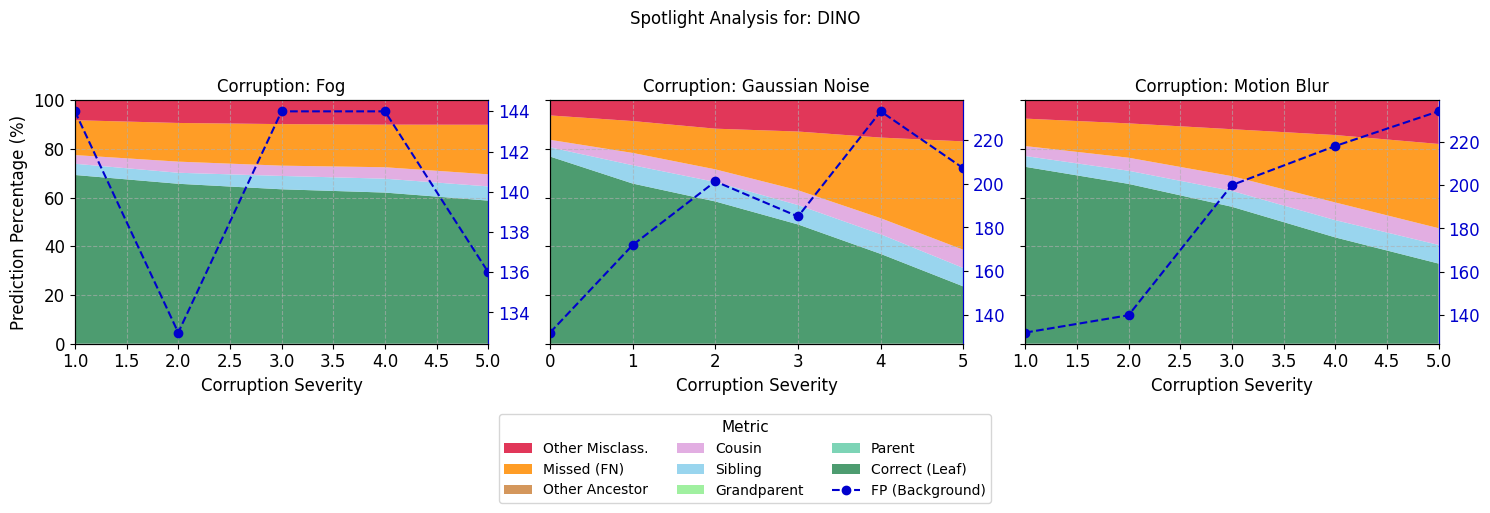

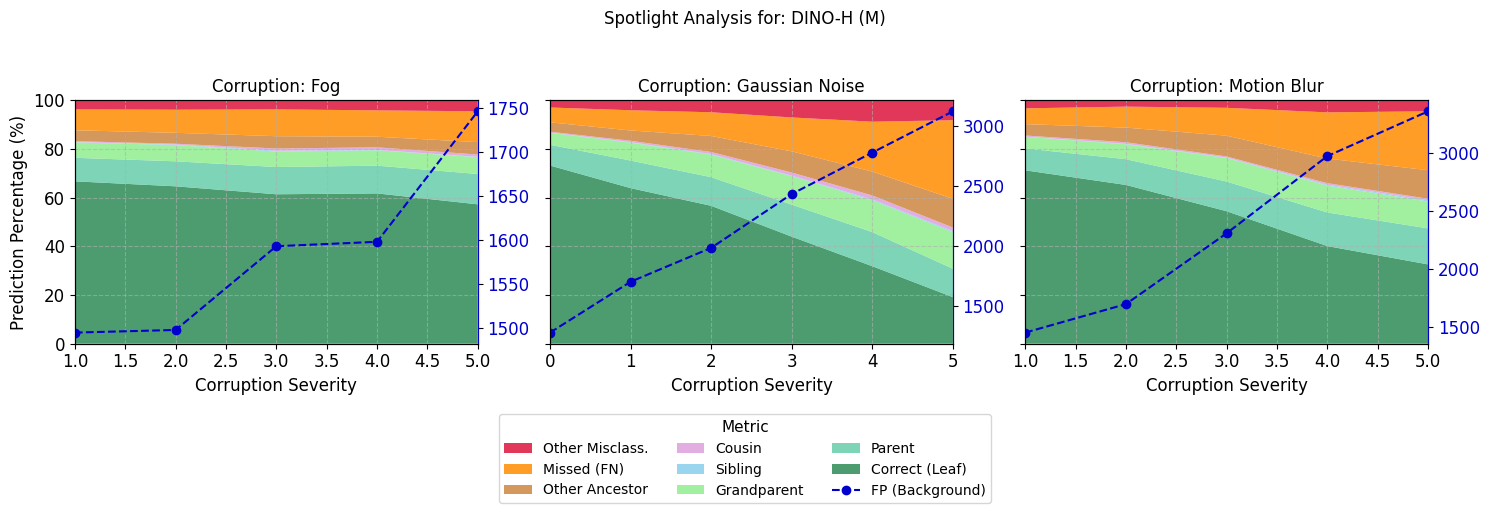

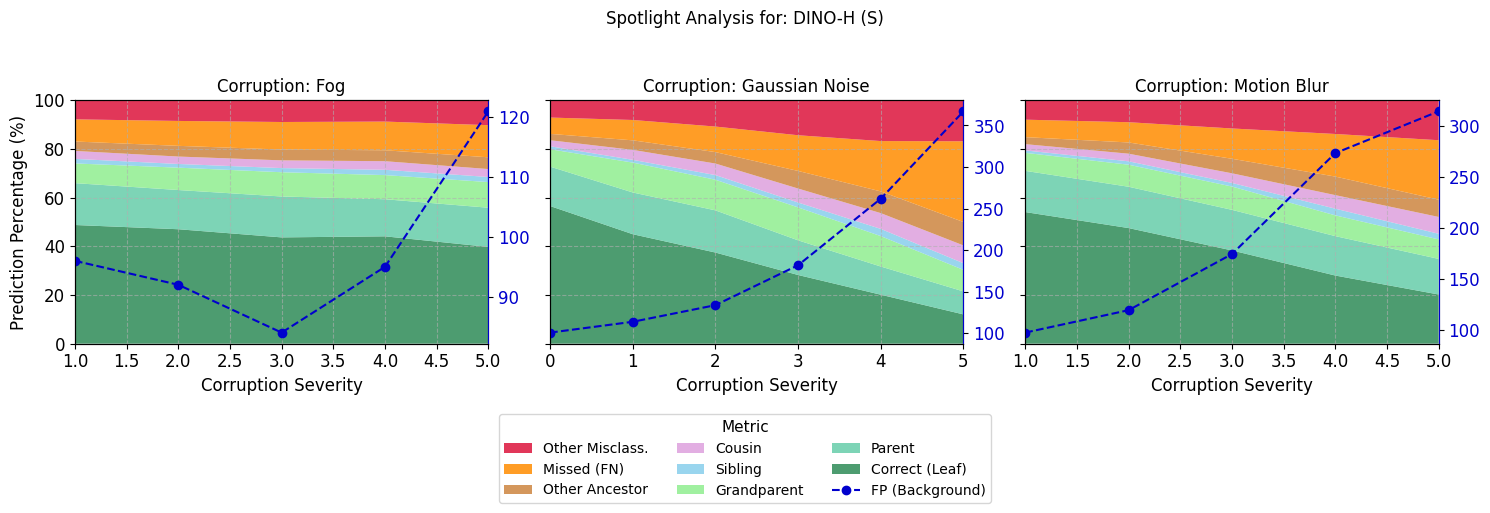

In [8]:
if not df.empty:
    spotlight_corruptions = ['Fog', 'Motion Blur', 'Gaussian Noise']
    spotlight_df = df[df['corruption'].isin(spotlight_corruptions)]

    if not spotlight_df.empty:
        for model_name in spotlight_df['model'].unique():
            model_df = spotlight_df[spotlight_df['model'] == model_name].copy()
            
            corruption_types = sorted(model_df['corruption'].unique())
            num_corruptions = len(corruption_types)
            
            if num_corruptions == 0:
                continue

            fig, axes = plt.subplots(
                nrows=1, 
                ncols=num_corruptions, 
                figsize=(5 * num_corruptions, 4), # Adjusted for better layout
                sharey=True,
                squeeze=False
            )
            axes = axes.flatten()

            fig.suptitle(f'Spotlight Analysis for: {model_name}', fontsize=12, y=1.0)

            for i, corruption_name in enumerate(corruption_types):
                ax = axes[i]
                corruption_df = model_df[model_df['corruption'] == corruption_name].sort_values('severity')
                
                x = corruption_df['severity'].values
                y_arrays = [corruption_df[metric].values for metric in available_metrics]
                
                labels = [plot_labels[metric] for metric in available_metrics]
                colors = [plot_colors[metric] for metric in available_metrics]
                
                # --- Stacked Area Plot for Percentages ---
                ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
                
                ax.set_title(f'Corruption: {corruption_name}', fontsize=12)
                ax.set_xlabel('Corruption Severity', fontsize=12)
                ax.tick_params(axis='x', labelsize=12)
                ax.set_ylim(0, 100)
                ax.set_xlim(min(x), max(x))
                ax.grid(True, linestyle='--', alpha=0.6)

                # --- Line Plot for FP count on secondary axis ---
                ax2 = ax.twinx()
                fp_counts = corruption_df['fp_bg'].values
                fp_label = plot_labels['fp_bg']
                fp_color = plot_colors['fp_bg']
                
                ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
                ax2.tick_params(axis='y', labelcolor=fp_color, labelsize=12)
                ax2.spines['right'].set_color(fp_color)

            axes[0].set_ylabel('Prediction Percentage (%)', fontsize=12)
            axes[0].tick_params(axis='y', labelsize=12)
            
            # Create a single shared legend for the figure
            lines, labels = axes[0].get_legend_handles_labels()
            lines2, labels2 = fig.axes[-1].get_legend_handles_labels()
            
            handles = list(reversed(lines)) + lines2
            labels = list(reversed(labels)) + labels2
            
            fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3, title='Metric', fontsize=10, title_fontsize=11)

            fig.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for legend
            plt.show()
    else:
        print("No data found for spotlight corruptions.")
else:
    print("DataFrame is empty. Cannot generate spotlight plots.")

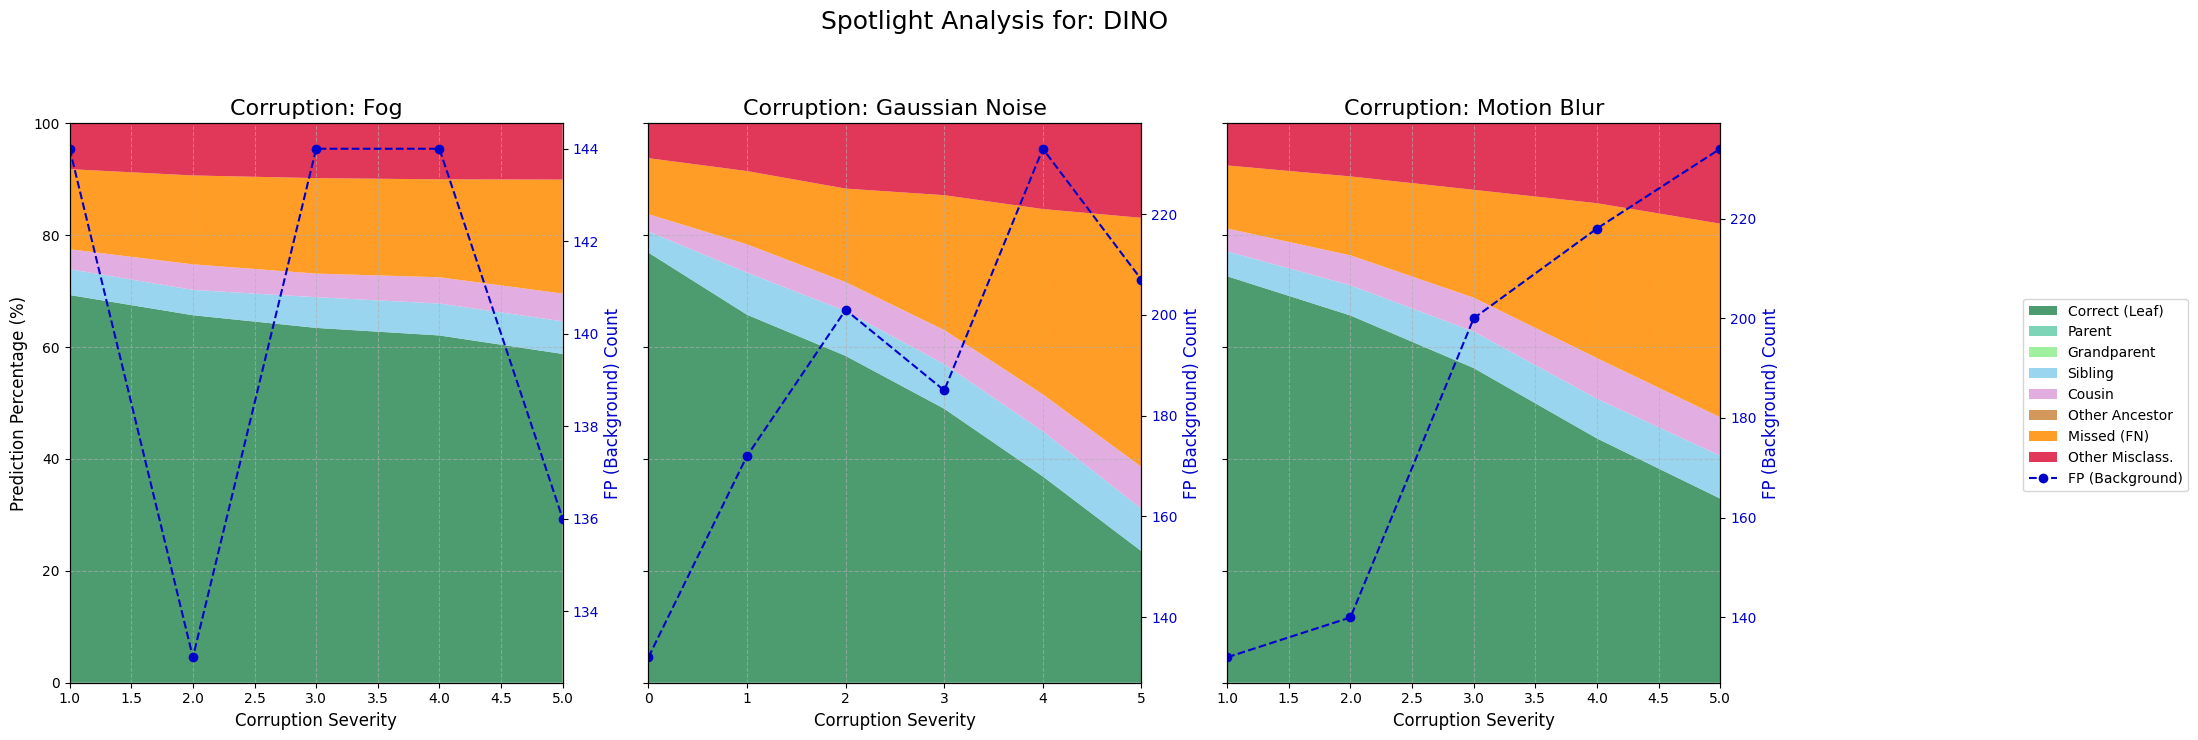

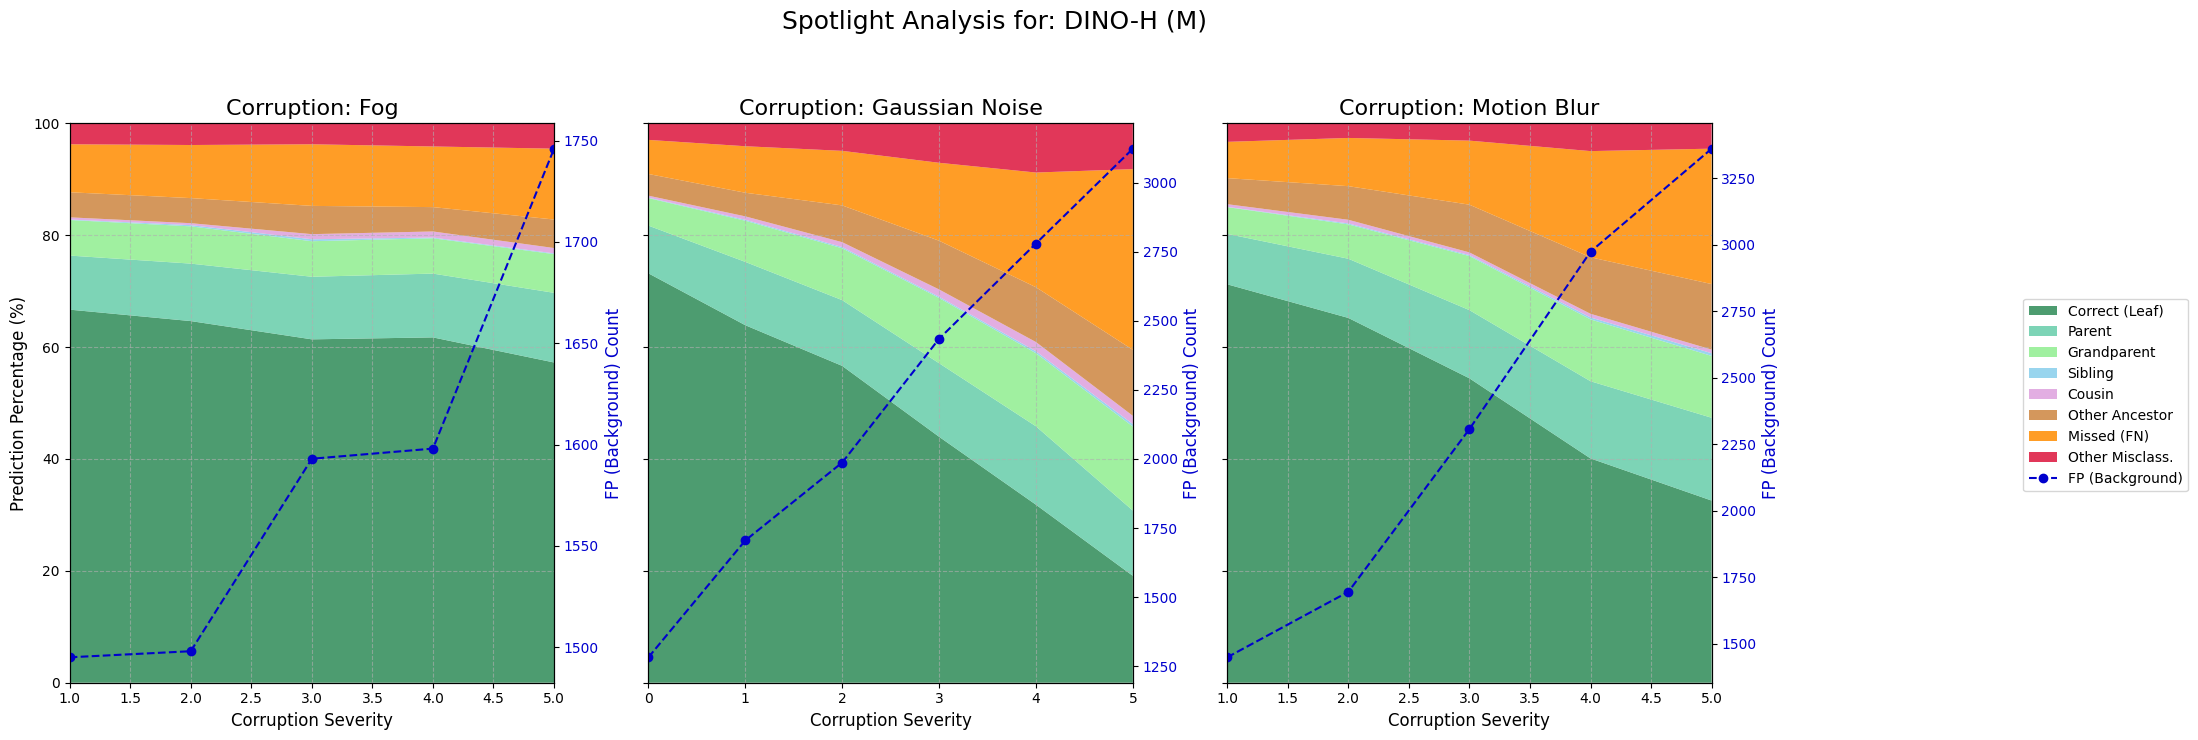

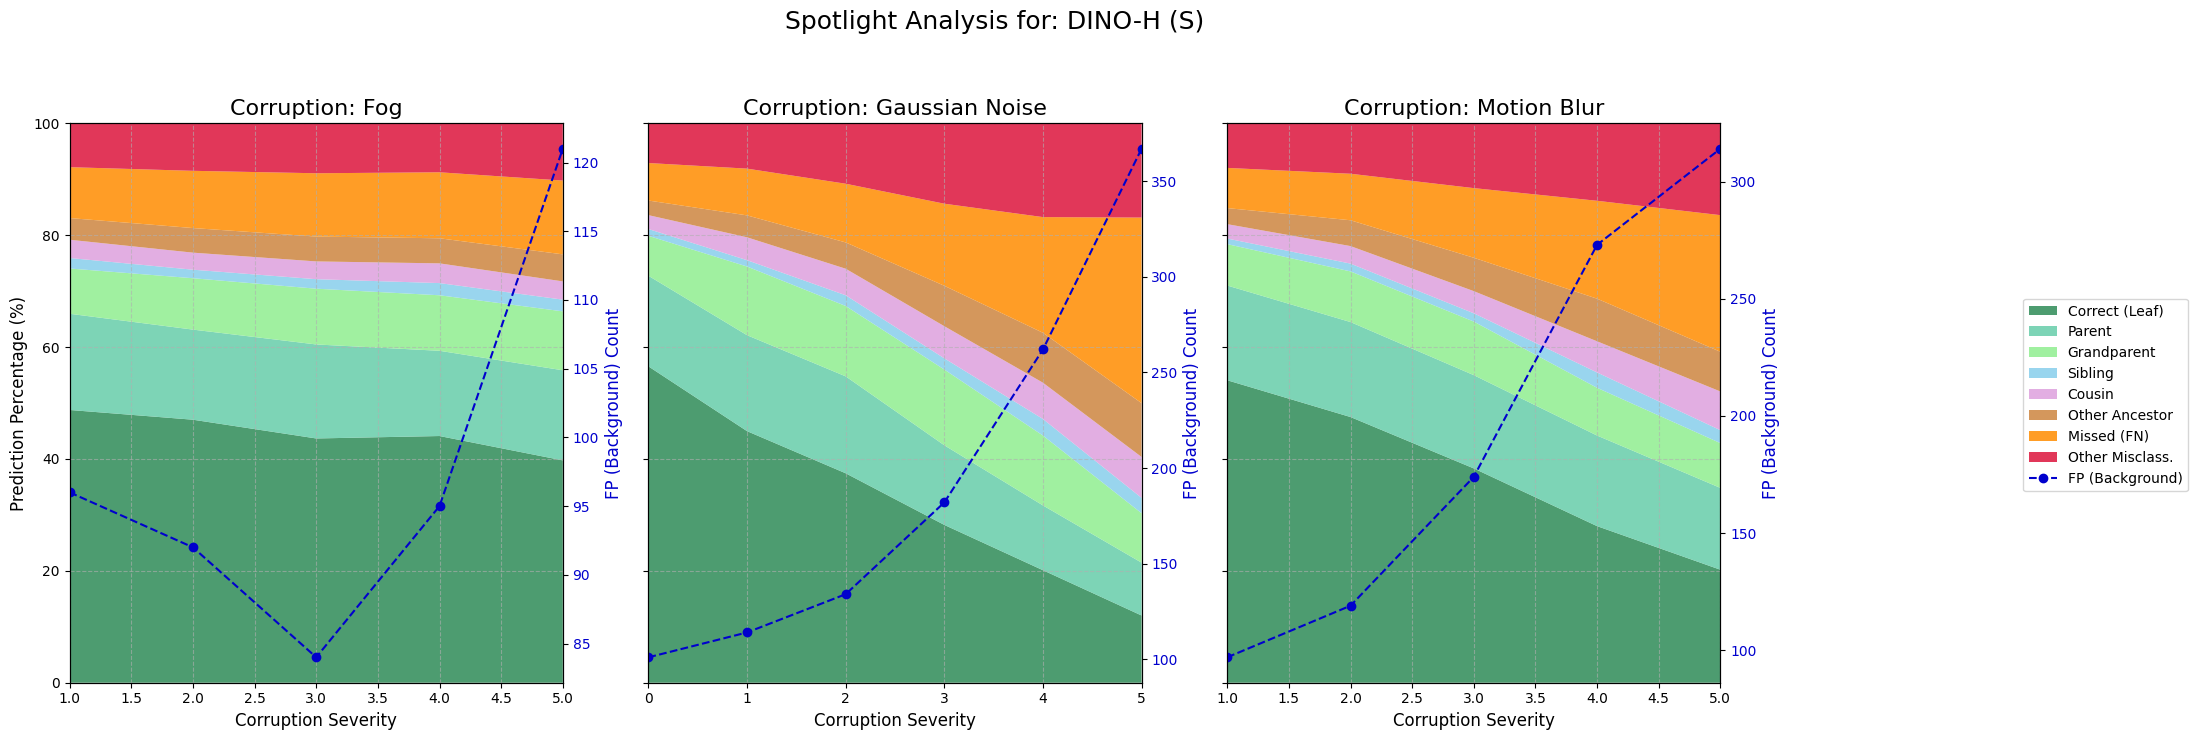

In [9]:
if not df.empty:
    spotlight_corruptions = ['Fog', 'Motion Blur', 'Gaussian Noise']
    spotlight_df = df[df['corruption'].isin(spotlight_corruptions)]

    if not spotlight_df.empty:
        for model_name in spotlight_df['model'].unique():
            model_df = spotlight_df[spotlight_df['model'] == model_name].copy()
            
            corruption_types = sorted(model_df['corruption'].unique())
            num_corruptions = len(corruption_types)
            
            if num_corruptions == 0:
                continue

            fig, axes = plt.subplots(
                nrows=1, 
                ncols=num_corruptions, 
                figsize=(20, 7), # Increased figure size for better legend placement
                sharey=True,
                squeeze=False
            )
            axes = axes.flatten()

            fig.suptitle(f'Spotlight Analysis for: {model_name}', fontsize=18, y=1.05)

            for i, corruption_name in enumerate(corruption_types):
                ax = axes[i]
                corruption_df = model_df[model_df['corruption'] == corruption_name].sort_values('severity')
                
                x = corruption_df['severity'].values
                y_arrays = [corruption_df[metric].values for metric in available_metrics]
                
                labels = [plot_labels[metric] for metric in available_metrics]
                colors = [plot_colors[metric] for metric in available_metrics]
                
                # --- Stacked Area Plot for Percentages ---
                ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
                
                ax.set_title(f'Corruption: {corruption_name}', fontsize=16)
                ax.set_xlabel('Corruption Severity', fontsize=12)
                ax.set_ylim(0, 100)
                ax.set_xlim(min(x), max(x))
                ax.grid(True, linestyle='--', alpha=0.6)

                # --- Line Plot for FP count on secondary axis ---
                ax2 = ax.twinx()
                fp_counts = corruption_df['fp_bg'].values
                fp_label = plot_labels['fp_bg']
                fp_color = plot_colors['fp_bg']
                
                ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
                ax2.set_ylabel('FP (Background) Count', fontsize=12, color=fp_color)
                ax2.tick_params(axis='y', labelcolor=fp_color)

            axes[0].set_ylabel('Prediction Percentage (%)', fontsize=12)
            
            # Create a single shared legend for the figure
            lines, labels = axes[0].get_legend_handles_labels()
            # Get handles from the last created secondary axis
            lines2, labels2 = fig.axes[-1].get_legend_handles_labels()
            fig.legend(lines + lines2, labels + labels2, loc='center right', bbox_to_anchor=(1.1, 0.5))

            fig.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout for legend
            plt.show()
    else:
        print("No data found for spotlight corruptions.")
else:
    print("DataFrame is empty. Cannot generate spotlight plots.")

### Part 3: Comprehensive Analysis (All Corruptions)

The following plots provide a detailed, comprehensive view of the performance for each model across all 15 benchmark corruptions. This allows for a thorough investigation of how models react to every type of image degradation tested.

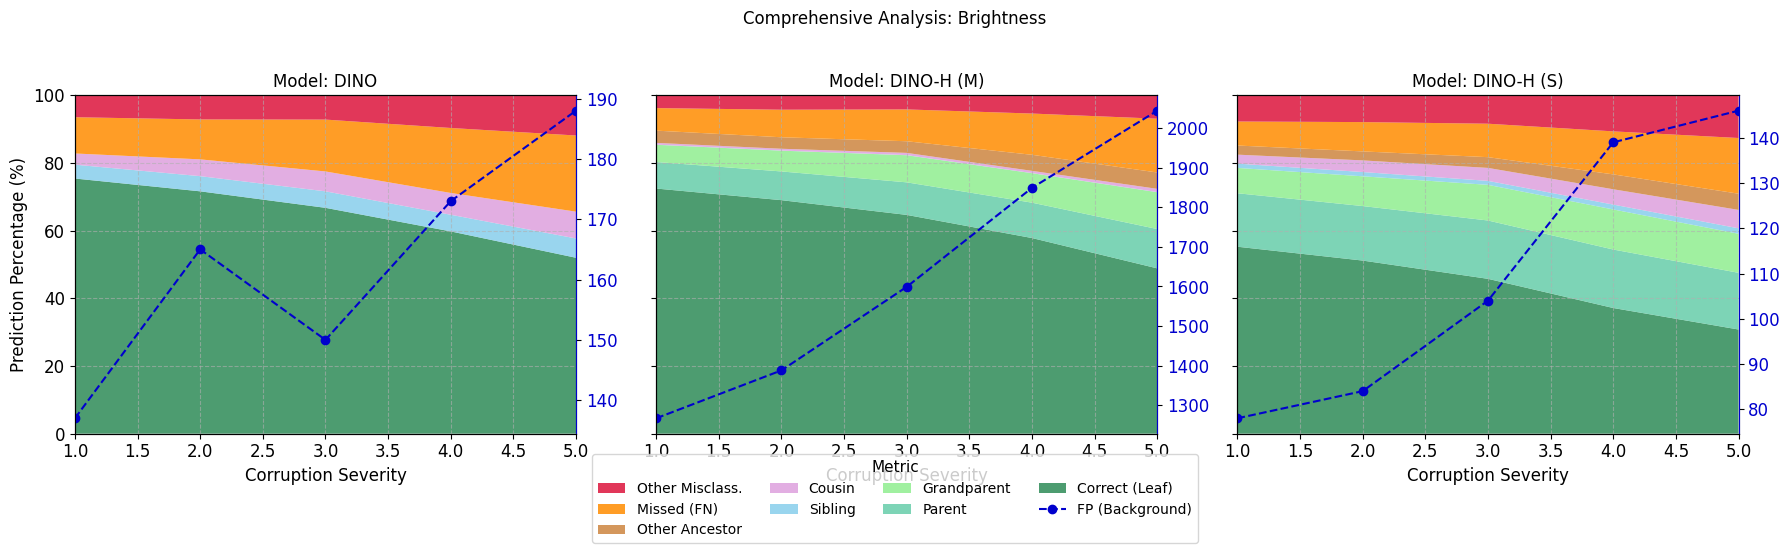

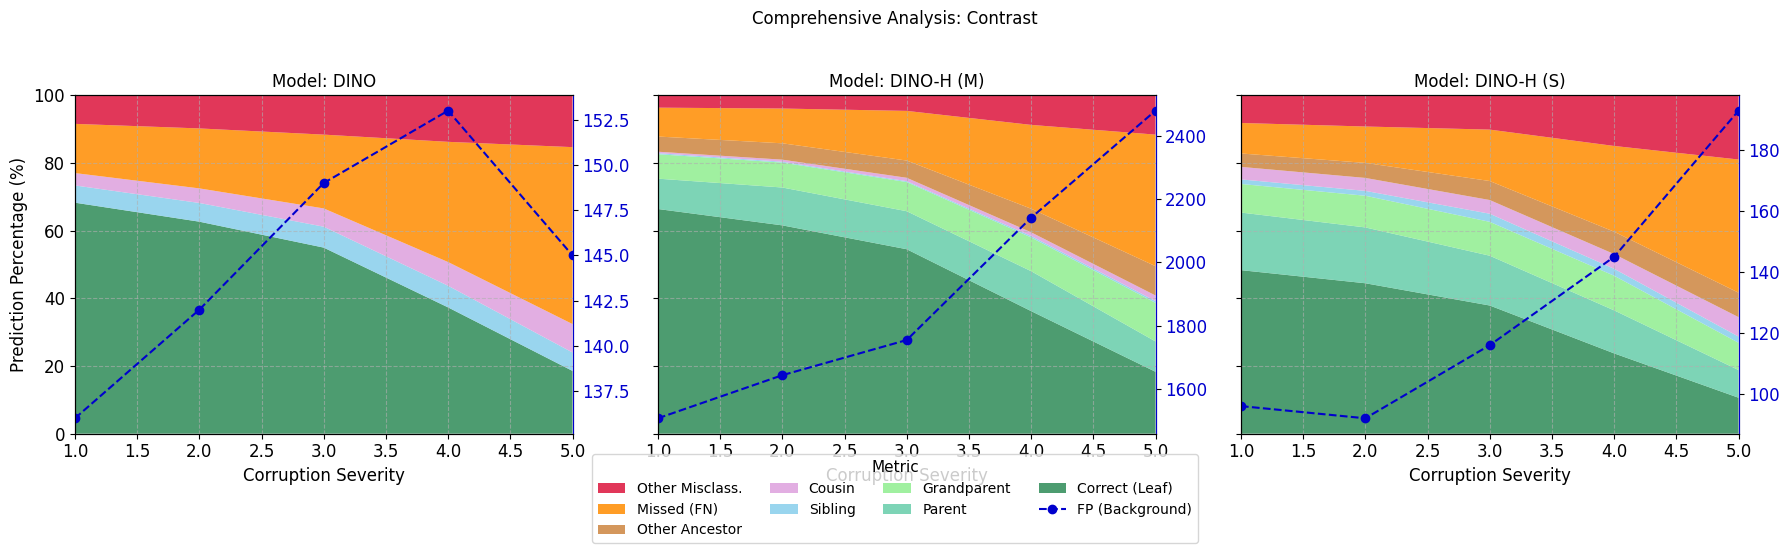

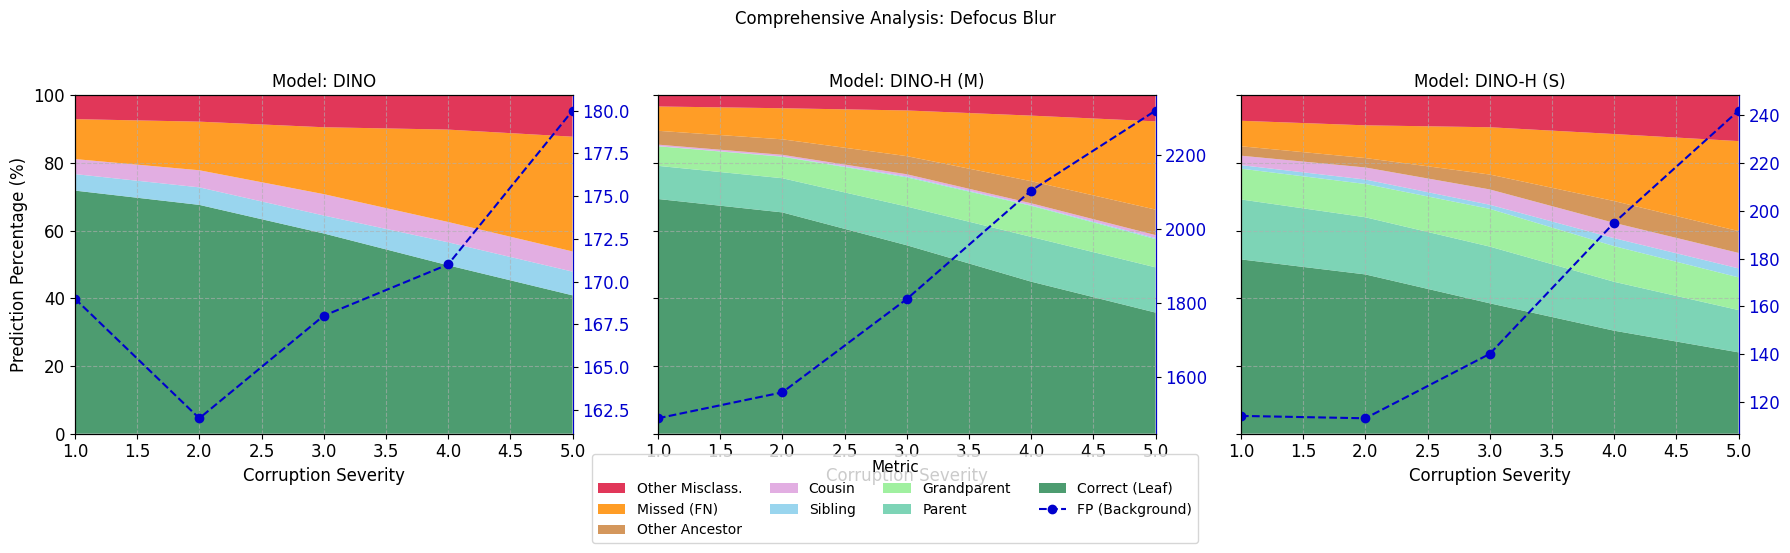

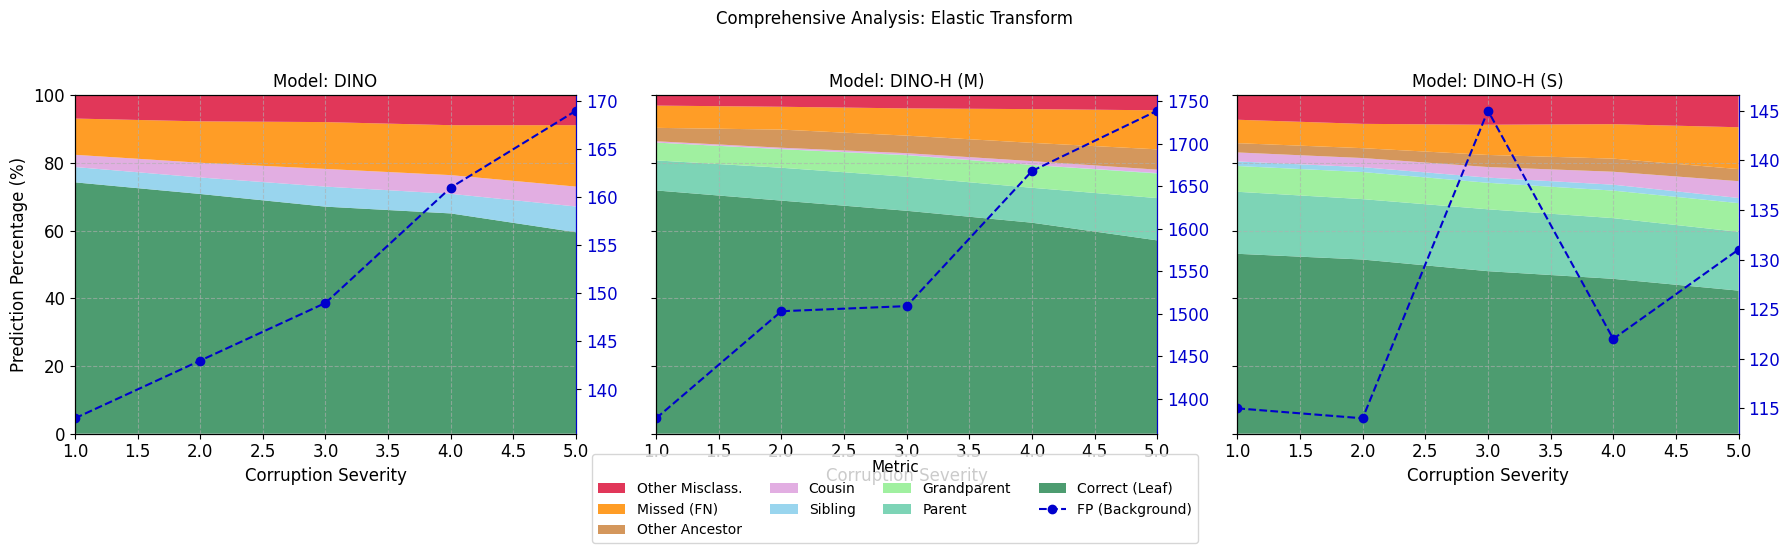

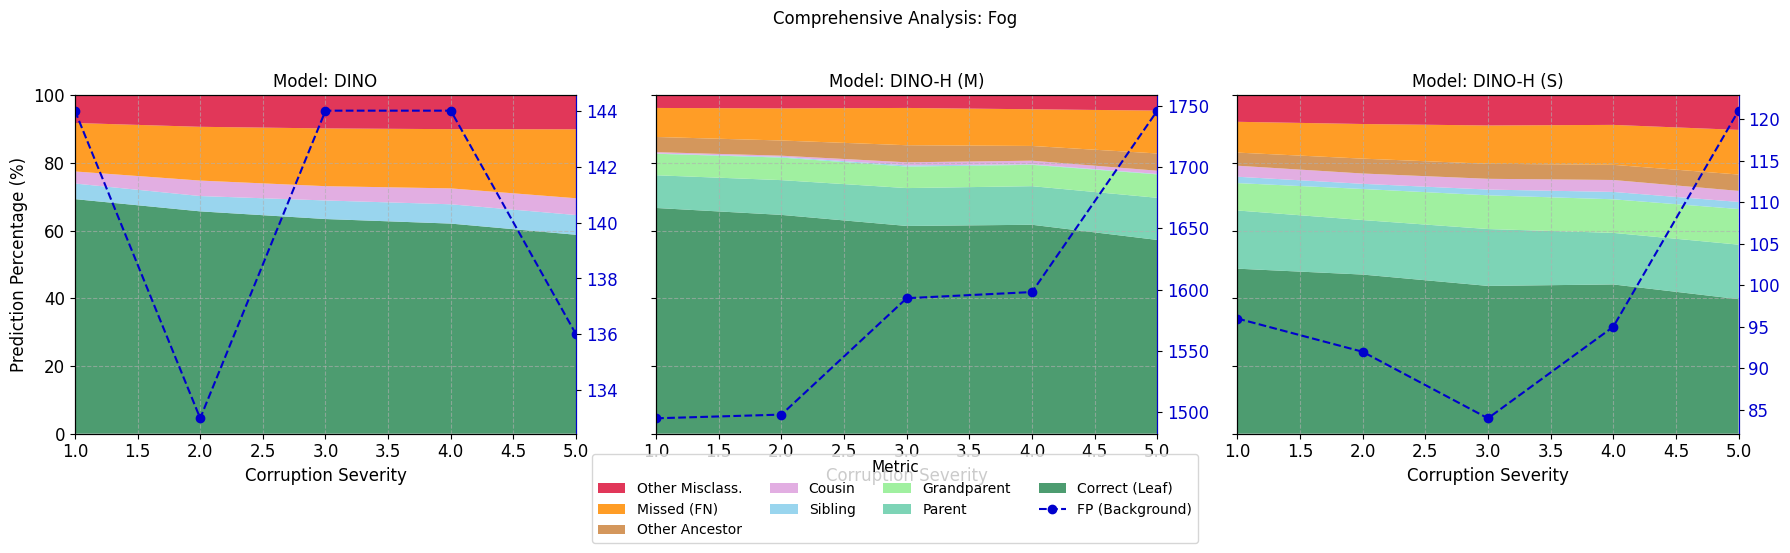

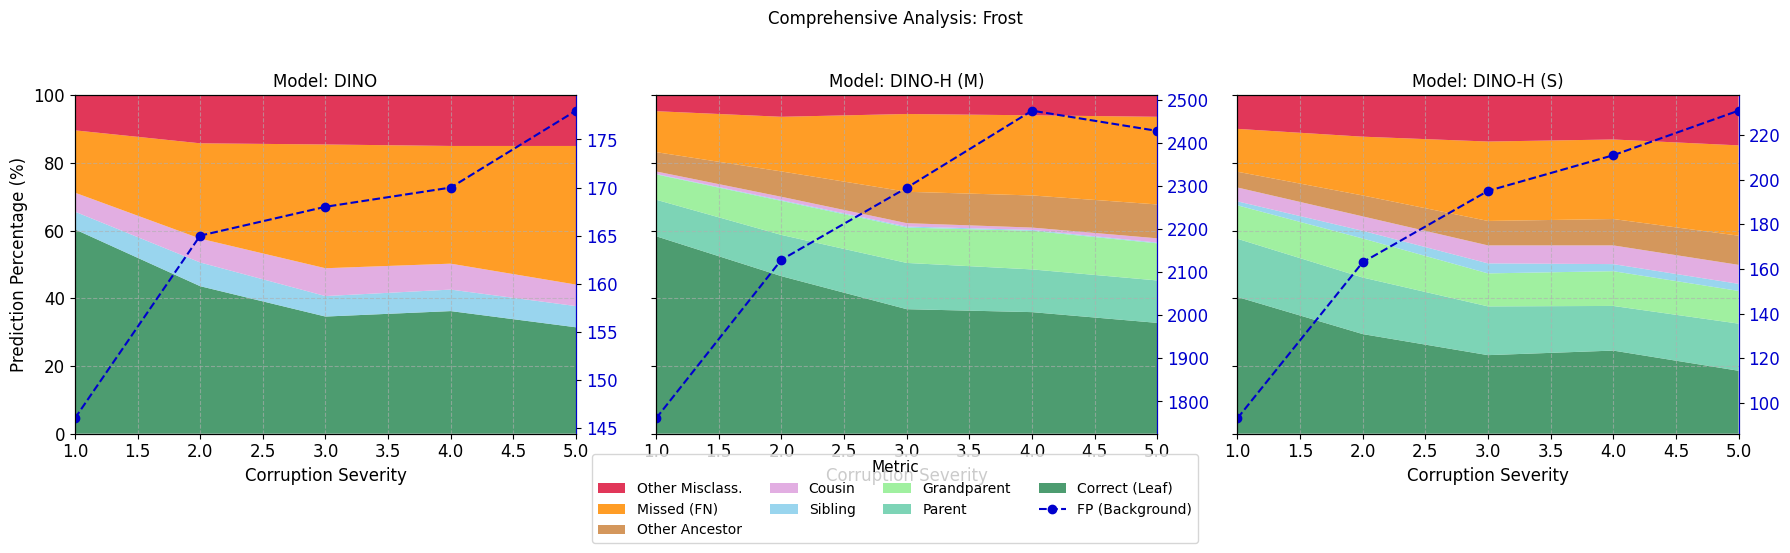

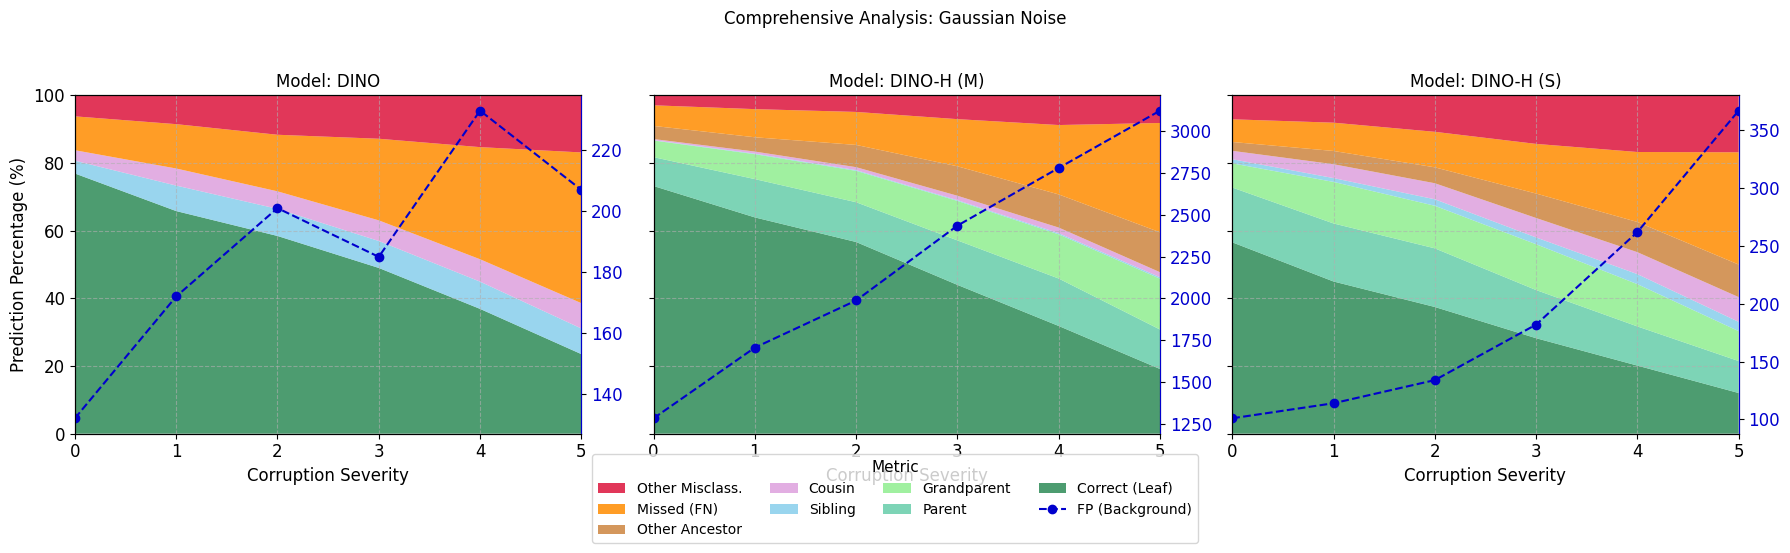

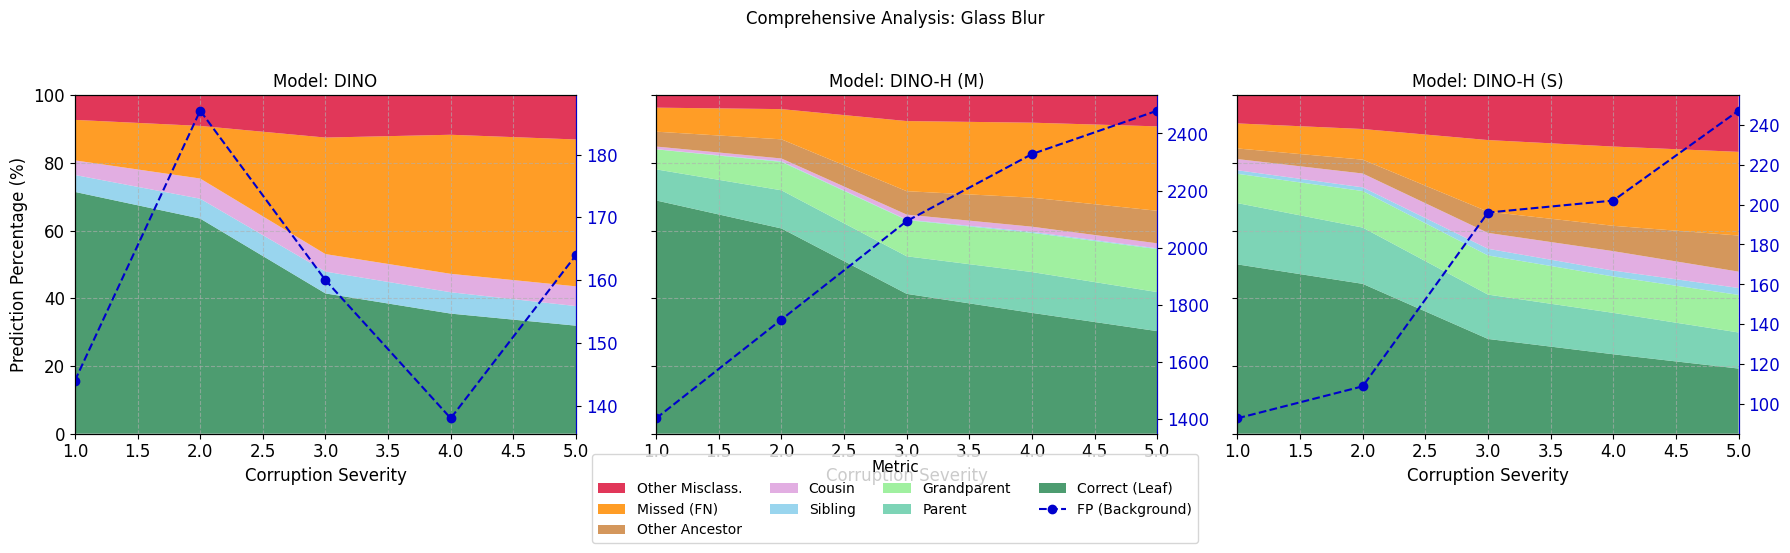

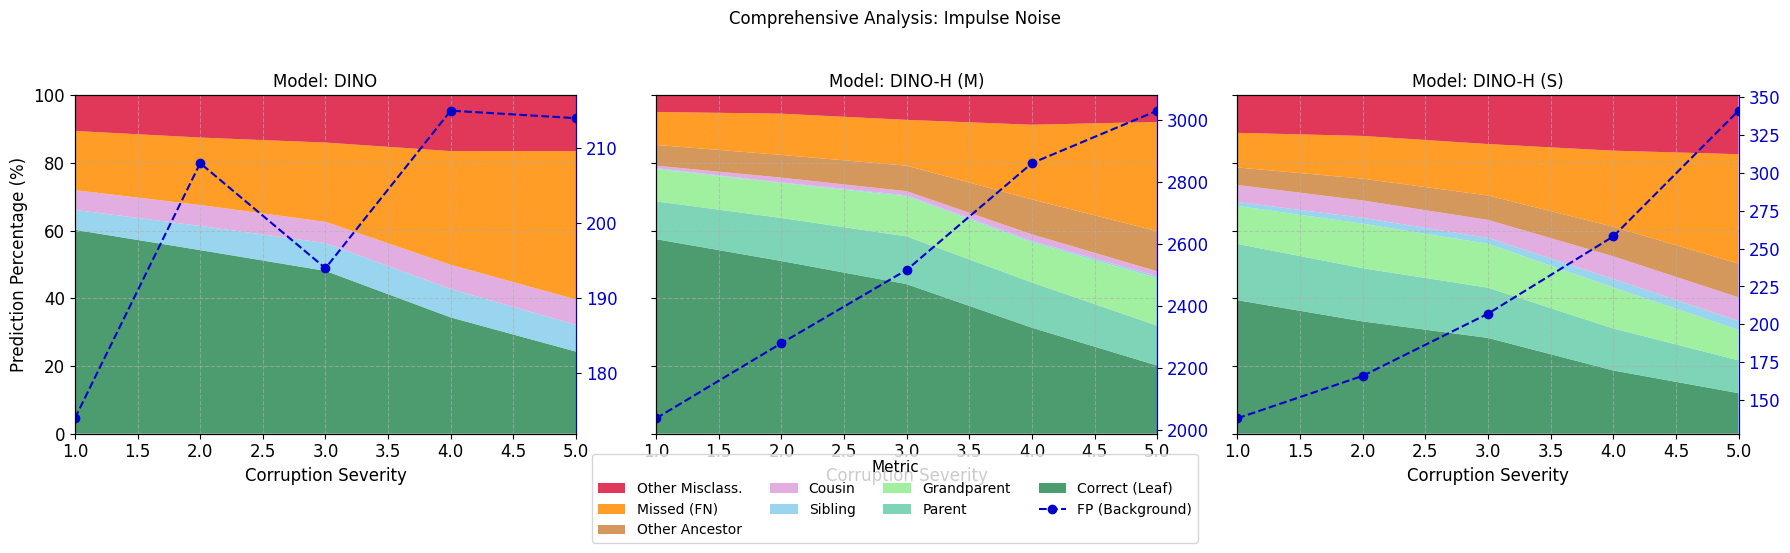

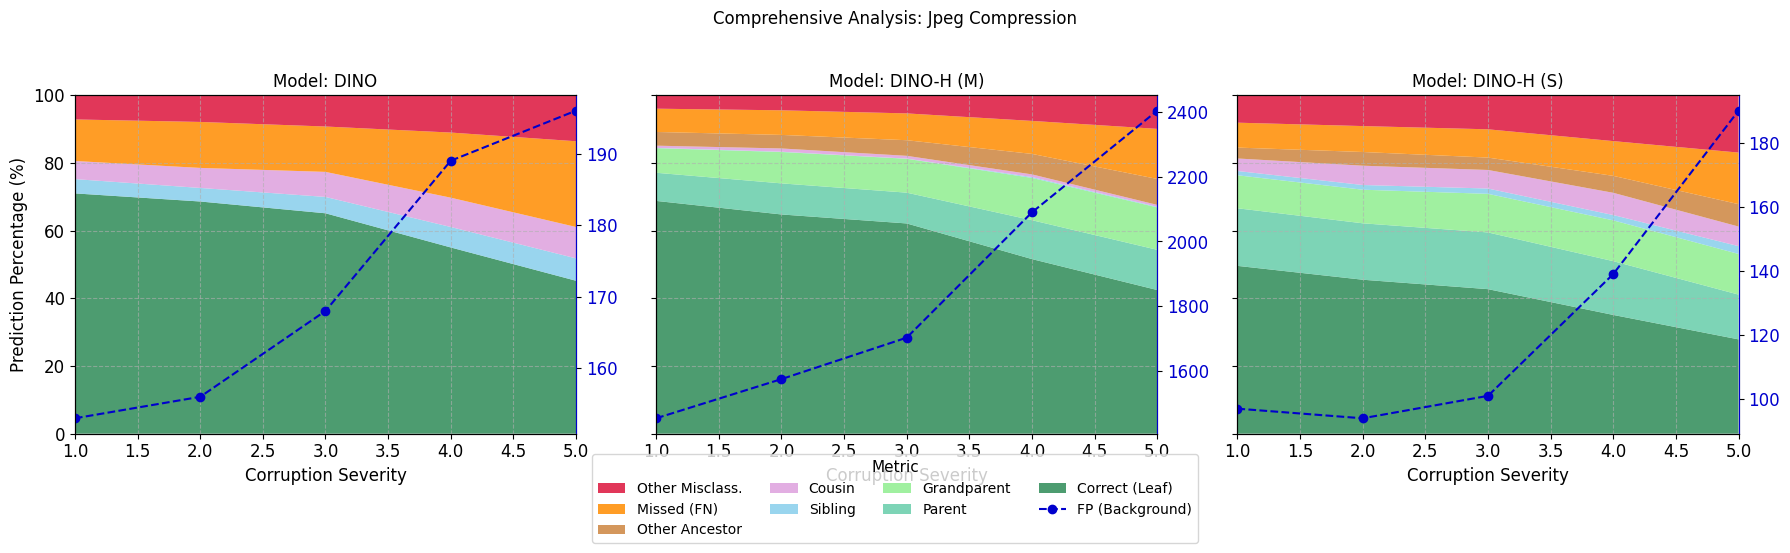

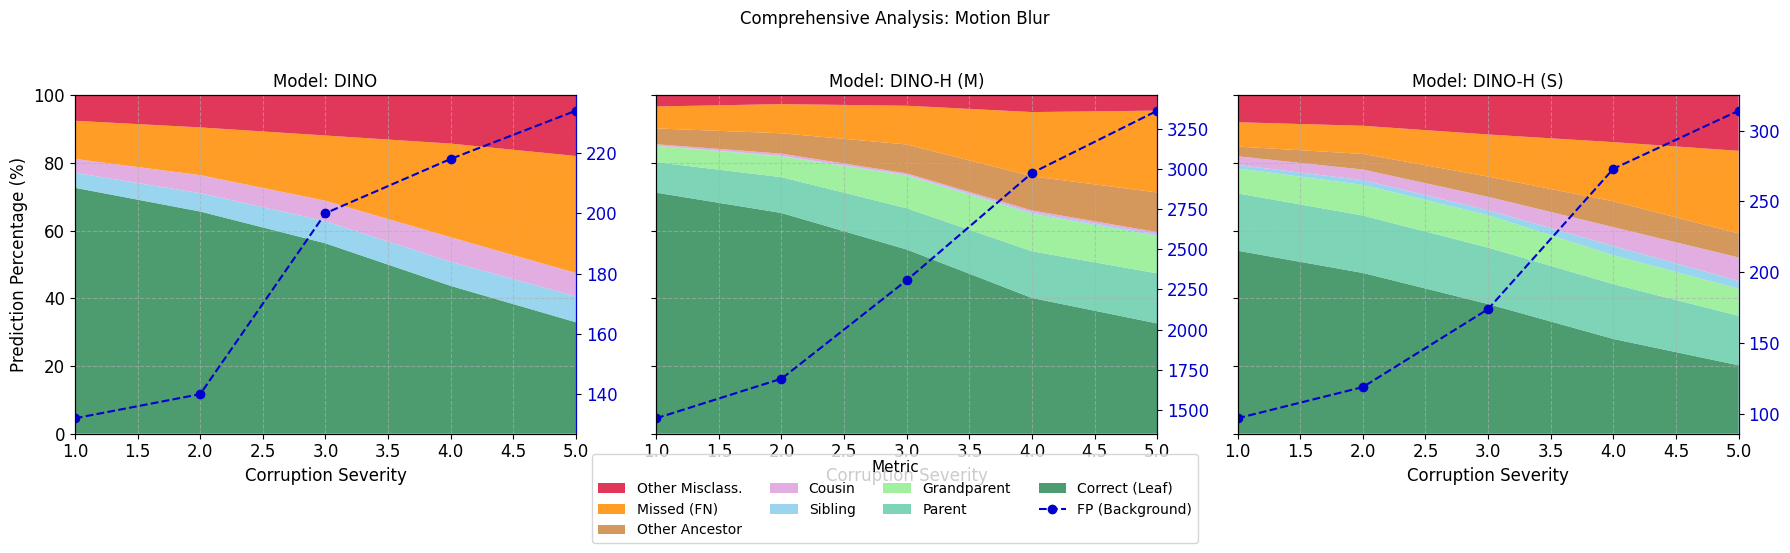

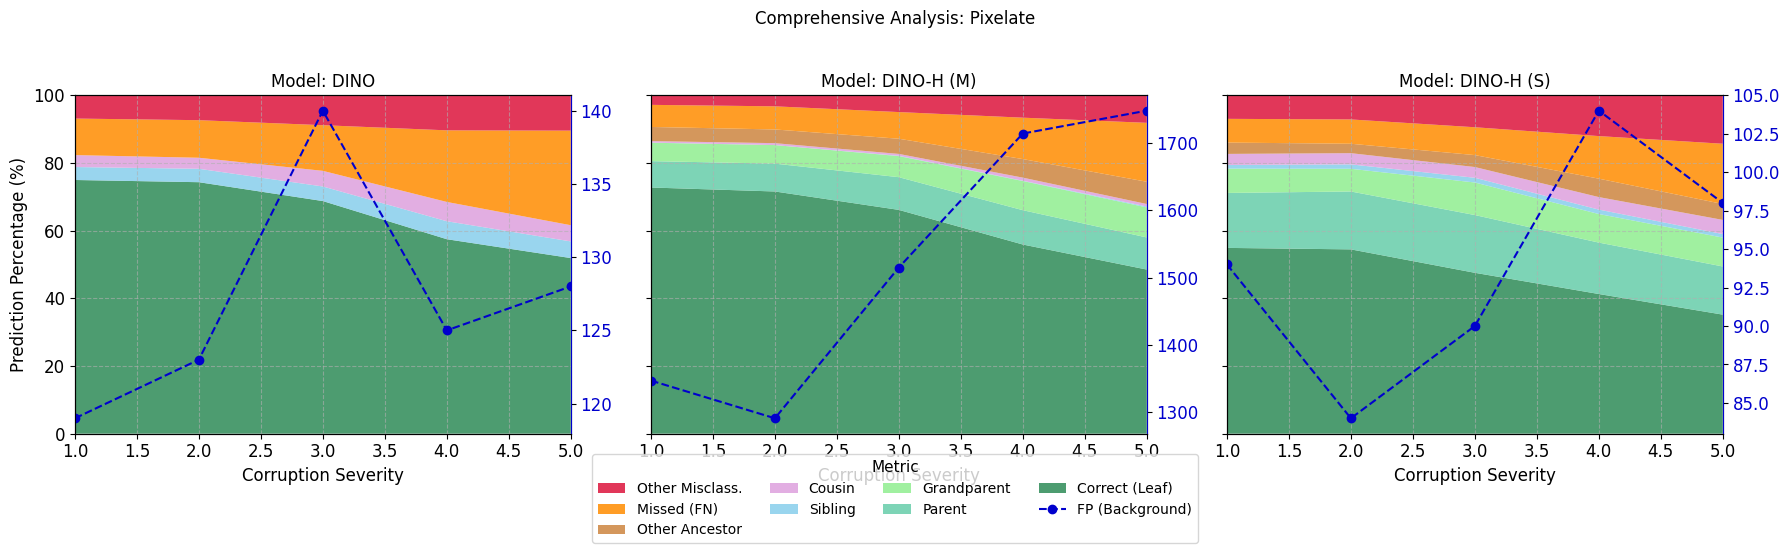

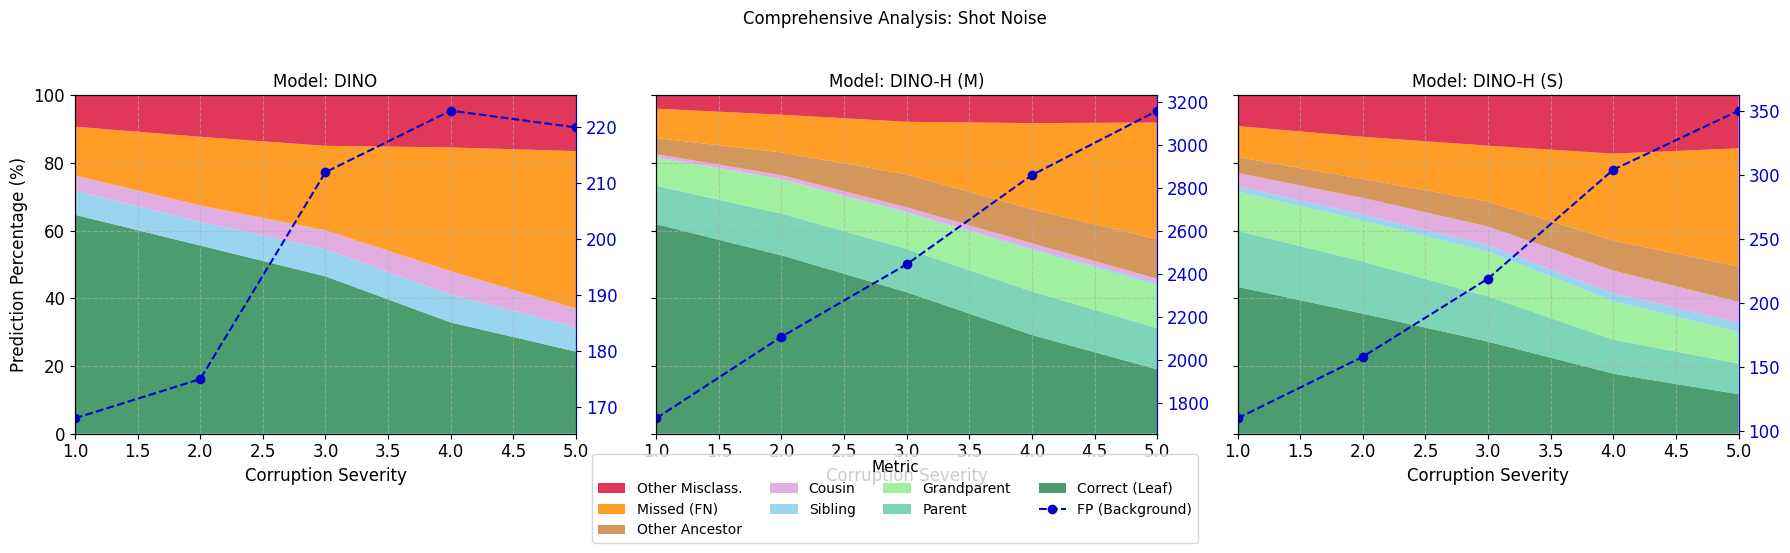

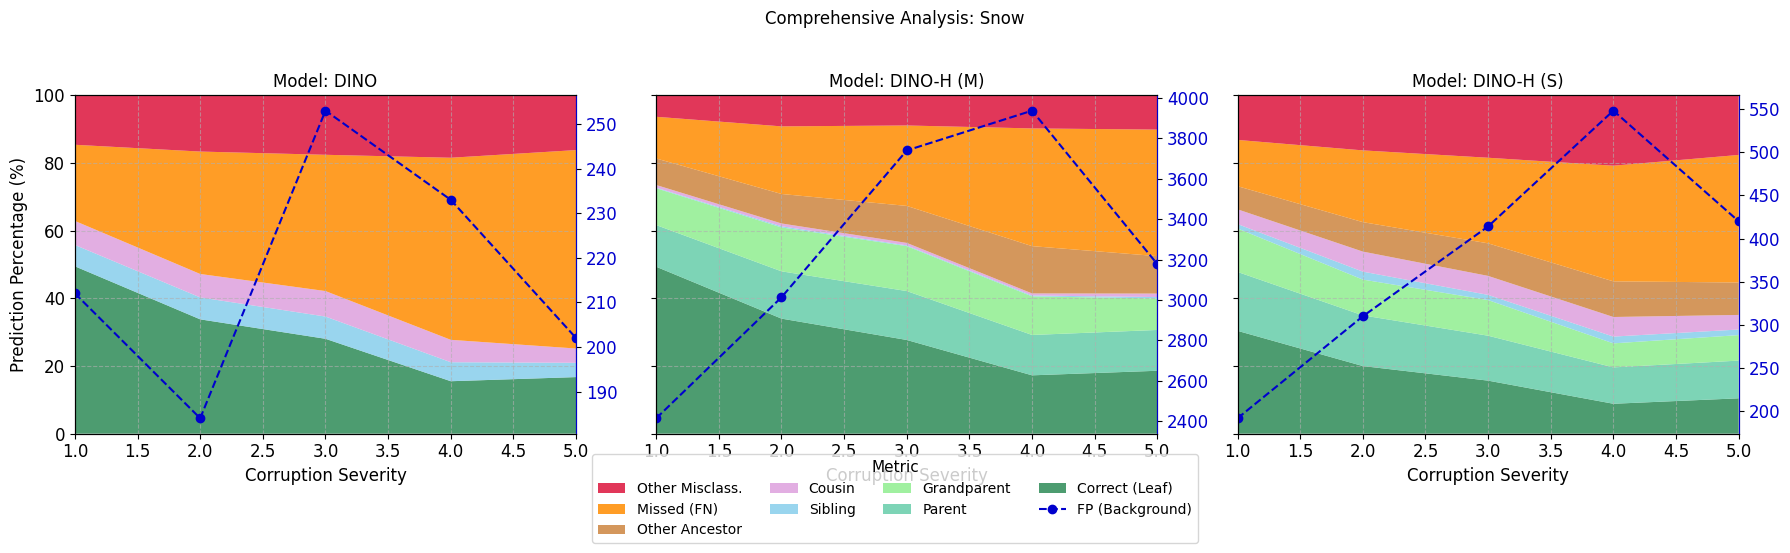

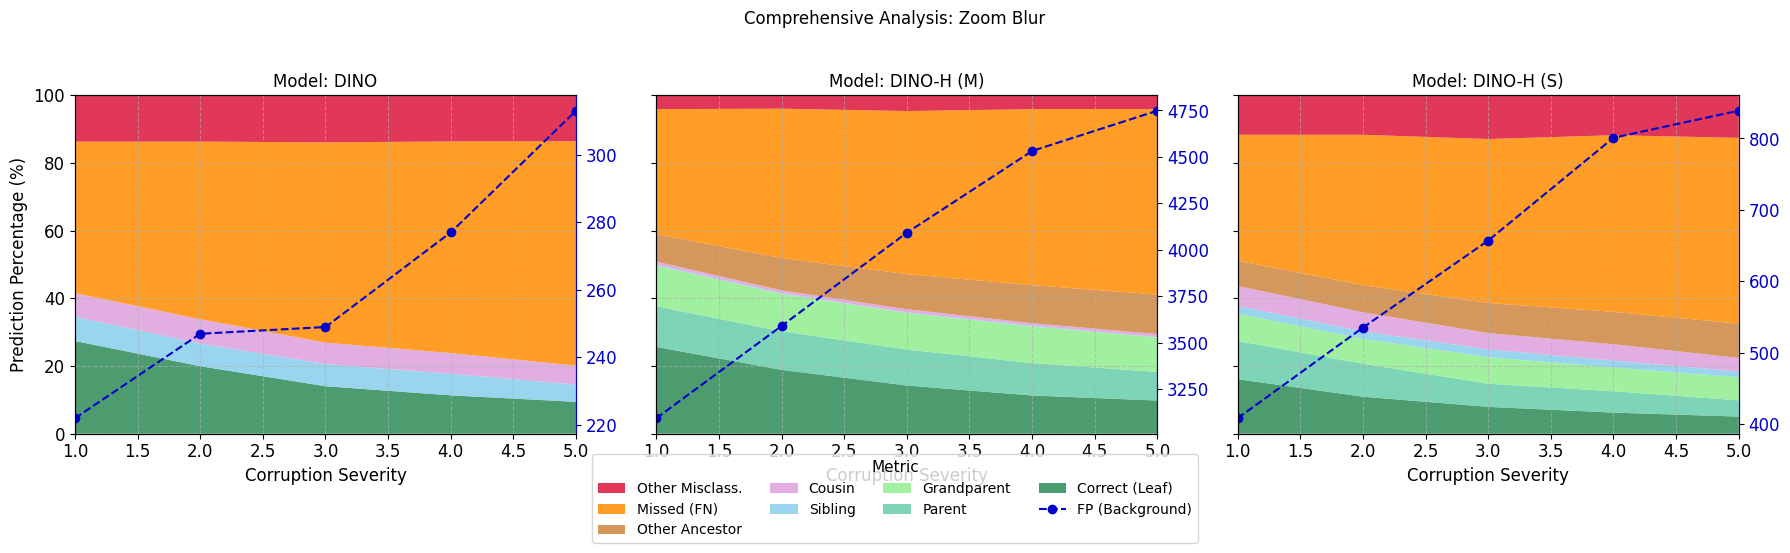

In [10]:


if not df.empty:
    corruption_types = sorted(df['corruption'].unique())
    model_names = df['model'].unique()
    num_models = len(model_names)

    # Generate a separate figure for each corruption type
    for corruption_name in corruption_types:
        fig, axes = plt.subplots(
            nrows=1, 
            ncols=num_models, 
            figsize=(6 * num_models, 5), # Adjusted for legend
            sharey=True
        )
        if num_models == 1:
            axes = [axes] # Make it iterable

        fig.suptitle(f'Comprehensive Analysis: {corruption_name}', fontsize=12, y=0.98)

        for i, model_name in enumerate(model_names):
            ax = axes[i]
            # Filter data for the specific model and corruption
            plot_df = df[(df['model'] == model_name) & (df['corruption'] == corruption_name)].sort_values('severity')
            
            if plot_df.empty:
                ax.set_title(f'Model: {model_name}\n(No data)', fontsize=12)
                continue

            # Prepare data for stackplot
            x = plot_df['severity'].values
            y_arrays = [plot_df[metric].values for metric in available_metrics]
            
            labels = [plot_labels[metric] for metric in available_metrics]
            colors = [plot_colors[metric] for metric in available_metrics]
            
            # --- Stacked Area Plot for Percentages ---
            ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
            
            ax.set_title(f'Model: {model_name}', fontsize=12)
            ax.set_xlabel('Corruption Severity', fontsize=12)
            ax.tick_params(axis='x', labelsize=12)
            ax.set_ylim(0, 100)
            ax.set_xlim(min(x), max(x))
            ax.grid(True, linestyle='--', alpha=0.6)

            # --- Line Plot for FP count on secondary axis ---
            ax2 = ax.twinx()
            fp_counts = plot_df['fp_bg'].values
            fp_label = plot_labels['fp_bg']
            fp_color = plot_colors['fp_bg']
            
            ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
            ax2.tick_params(axis='y', labelcolor=fp_color, labelsize=12)
            ax2.spines['right'].set_color(fp_color)

        # Common Y label
        axes[0].set_ylabel('Prediction Percentage (%)', fontsize=12)
        axes[0].tick_params(axis='y', labelsize=12)
        
        # Create a single shared legend for the figure
        lines, labels = axes[0].get_legend_handles_labels()
        ax2_handles, ax2_labels = fig.axes[-1].get_legend_handles_labels()
        
        handles = list(reversed(lines)) + ax2_handles
        labels = list(reversed(labels)) + ax2_labels
        
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, title='Metric', fontsize=10, title_fontsize=11)

        # Adjust layout
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        
        plt.show()
else:
    print("DataFrame is empty. Cannot generate plots.")

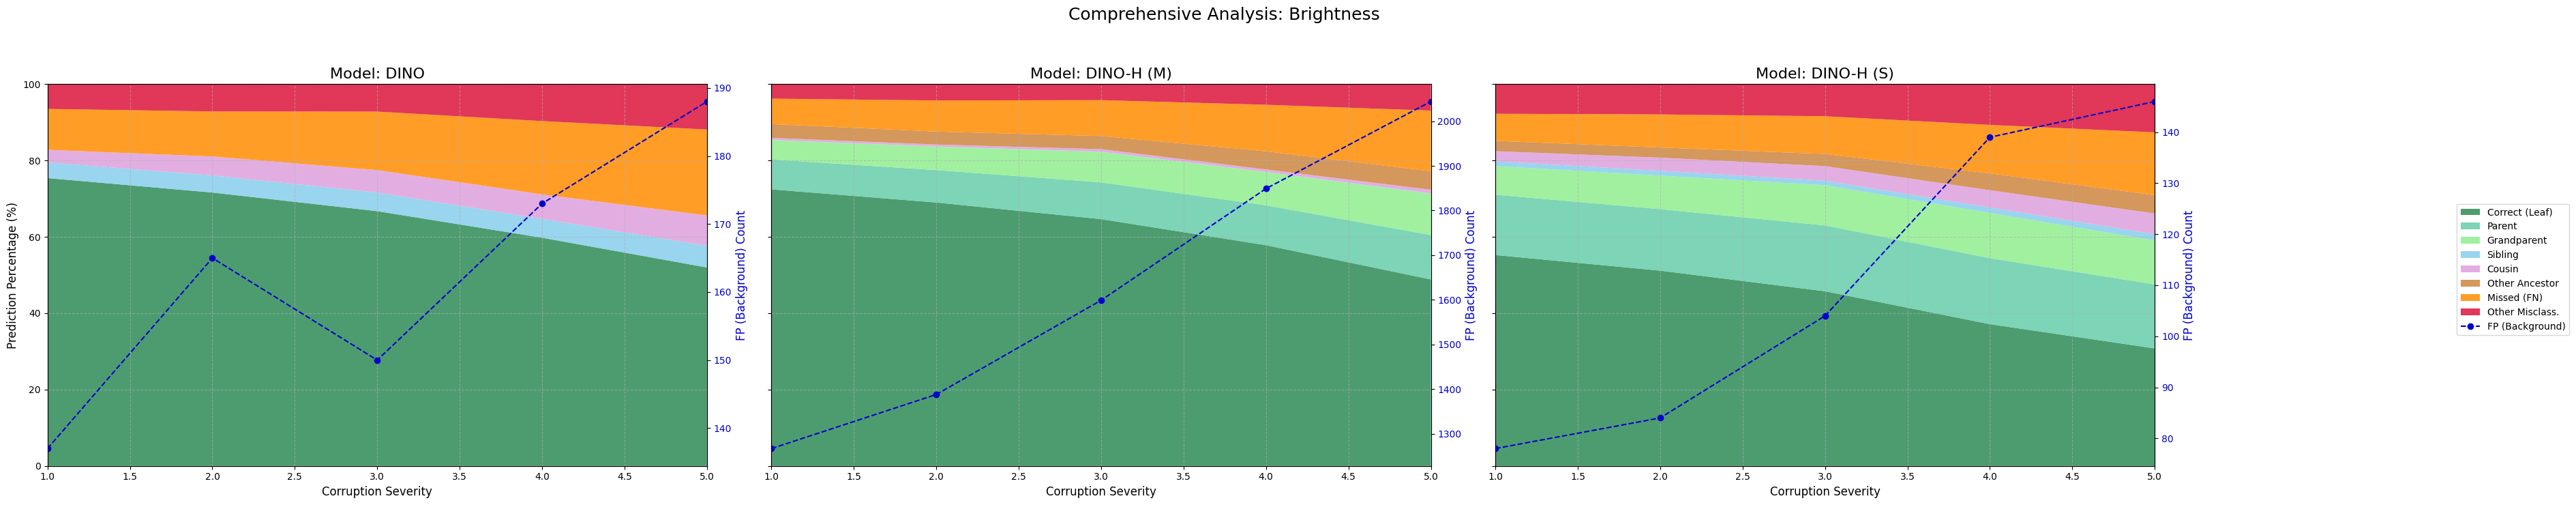

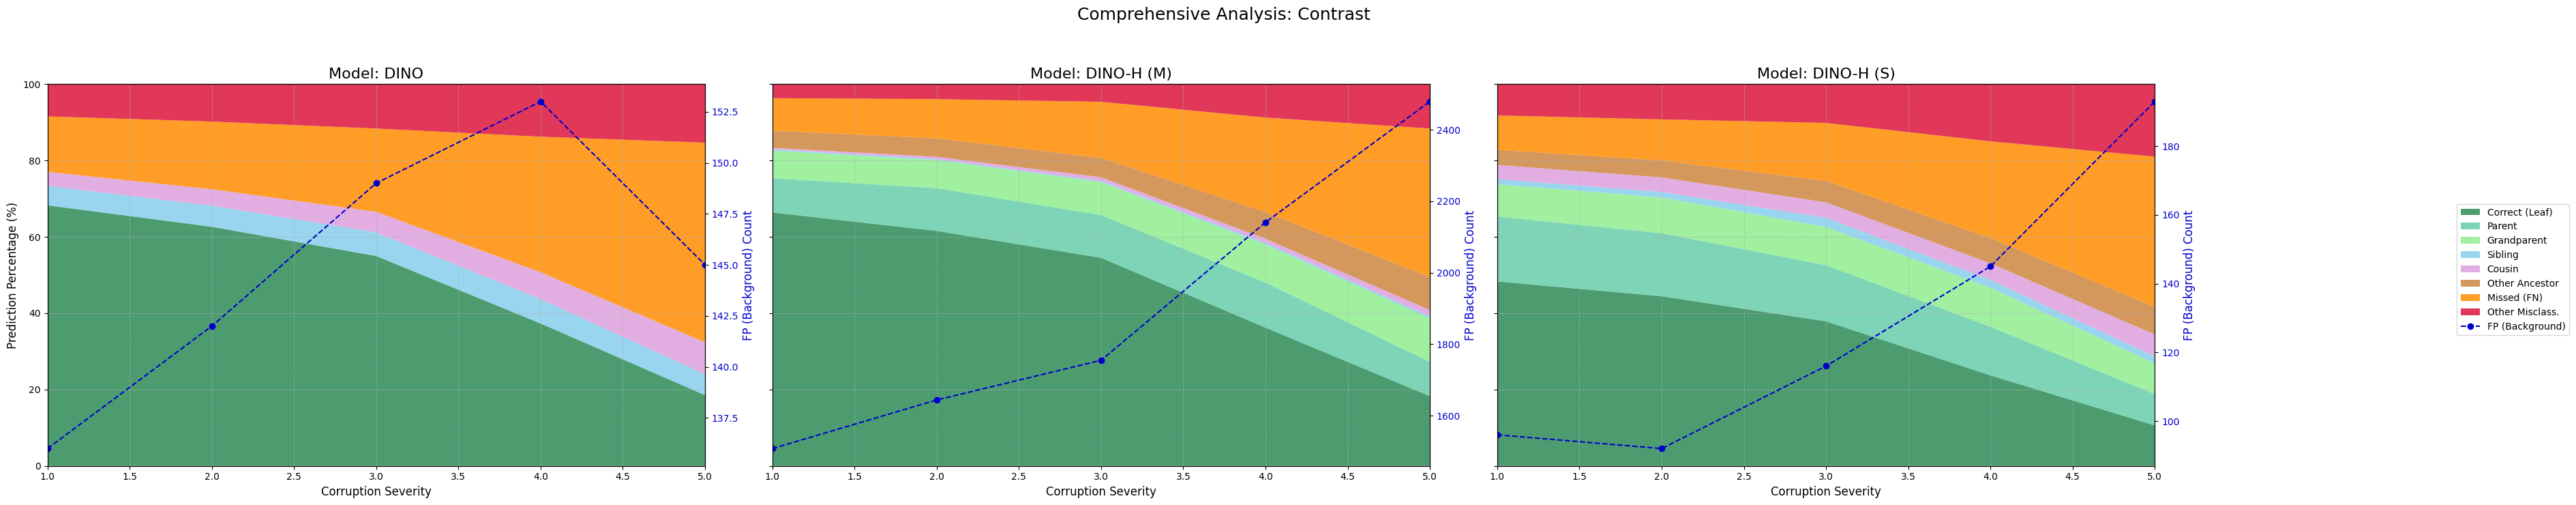

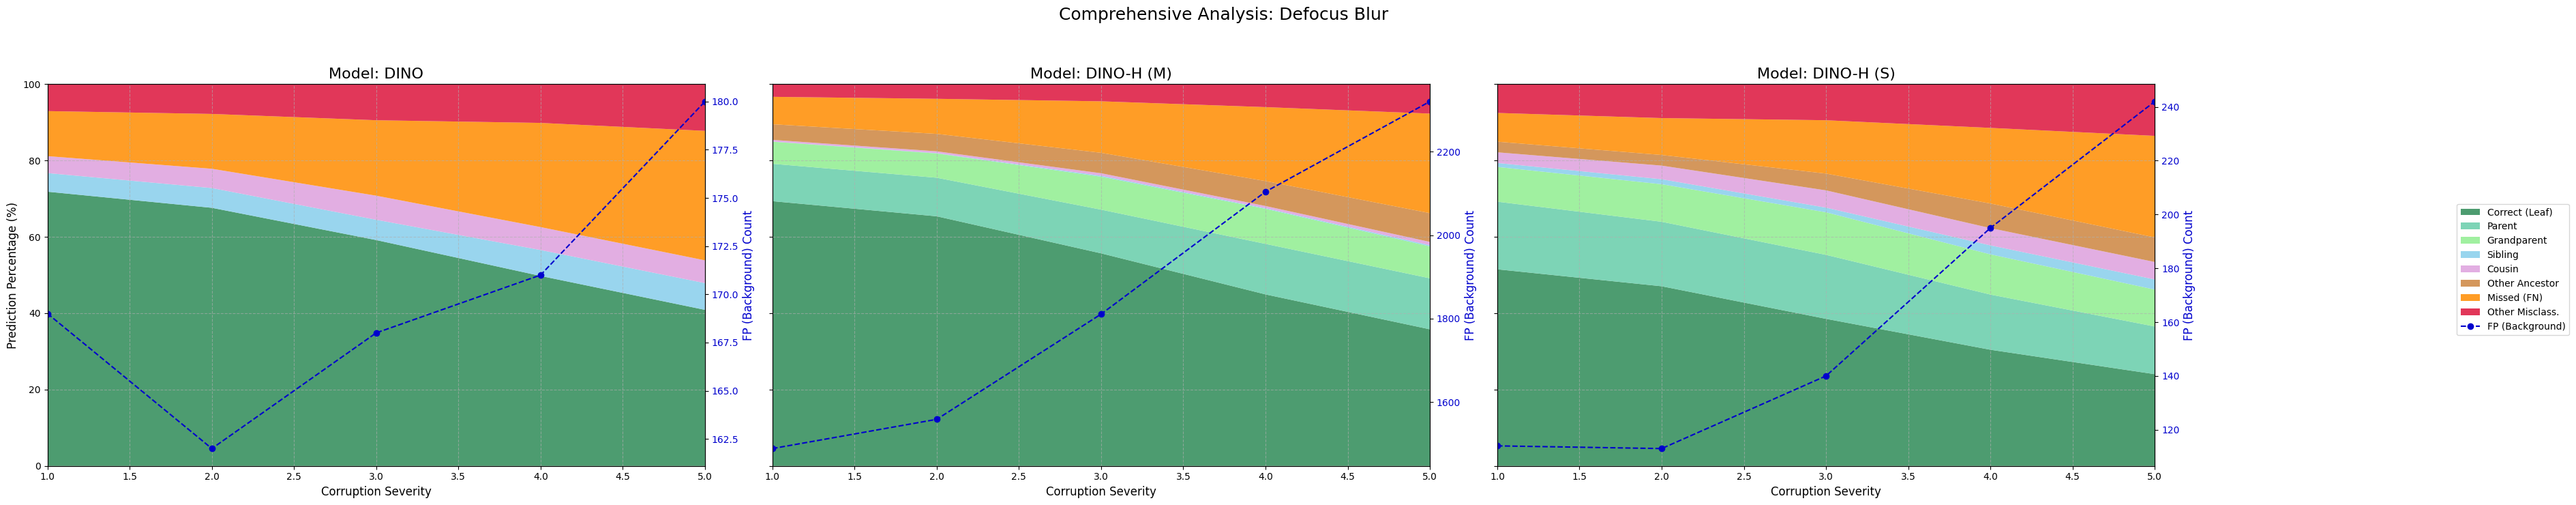

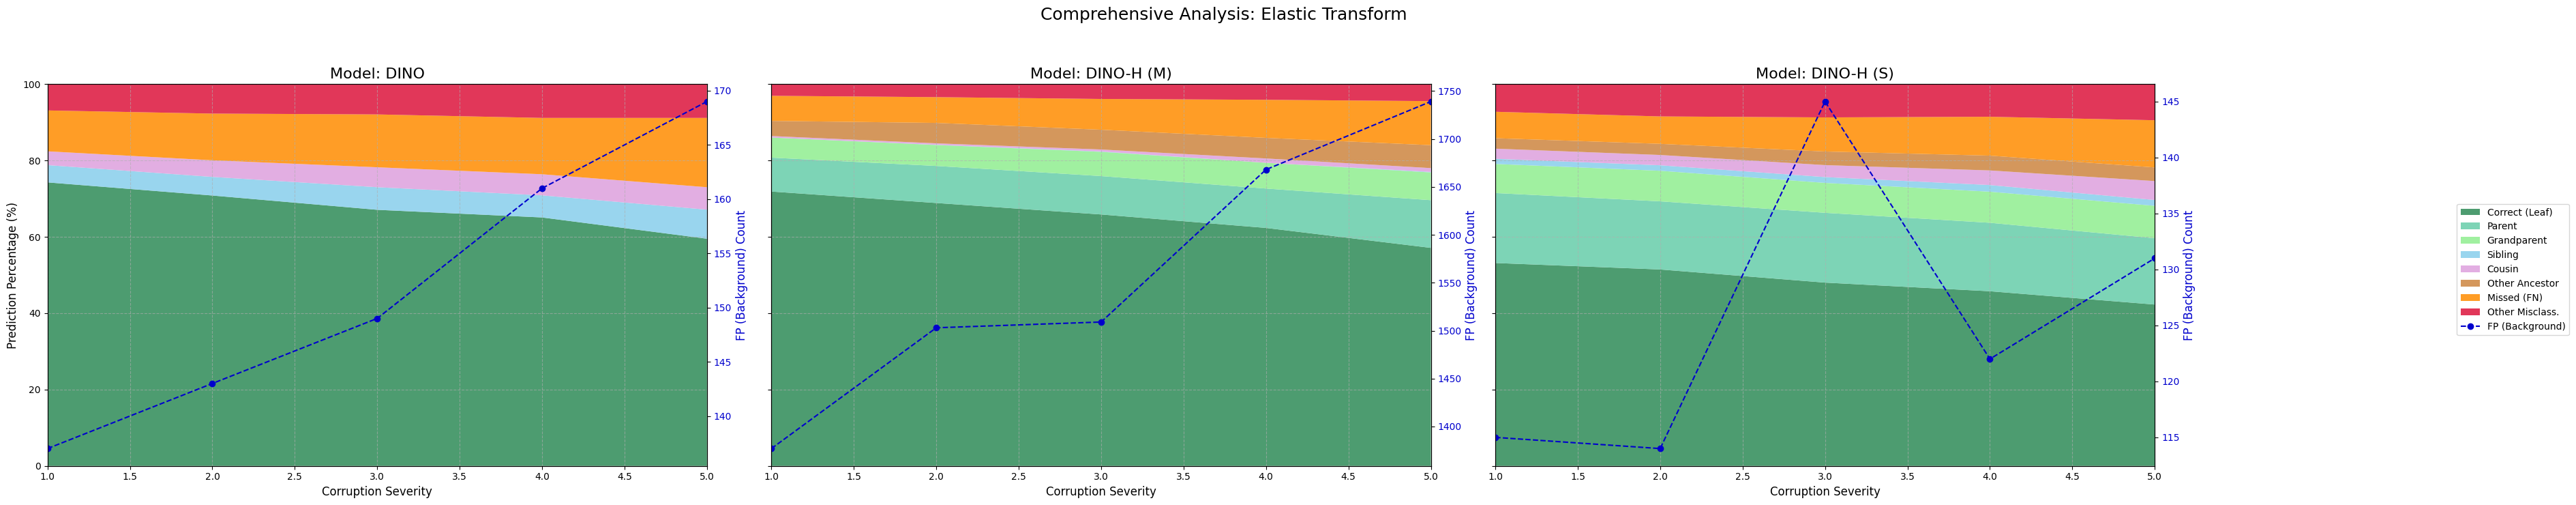

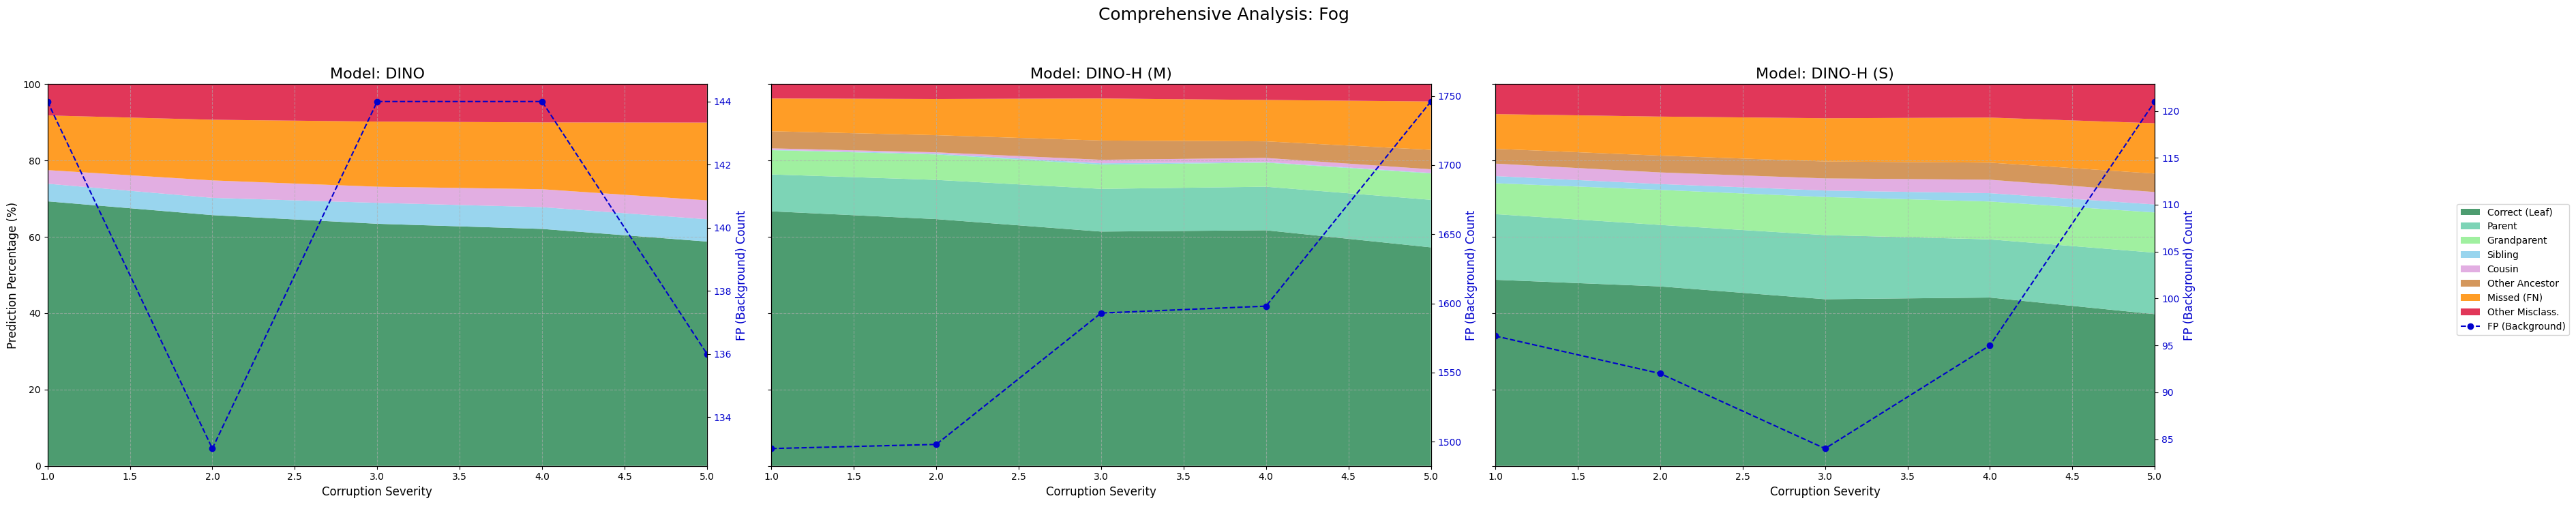

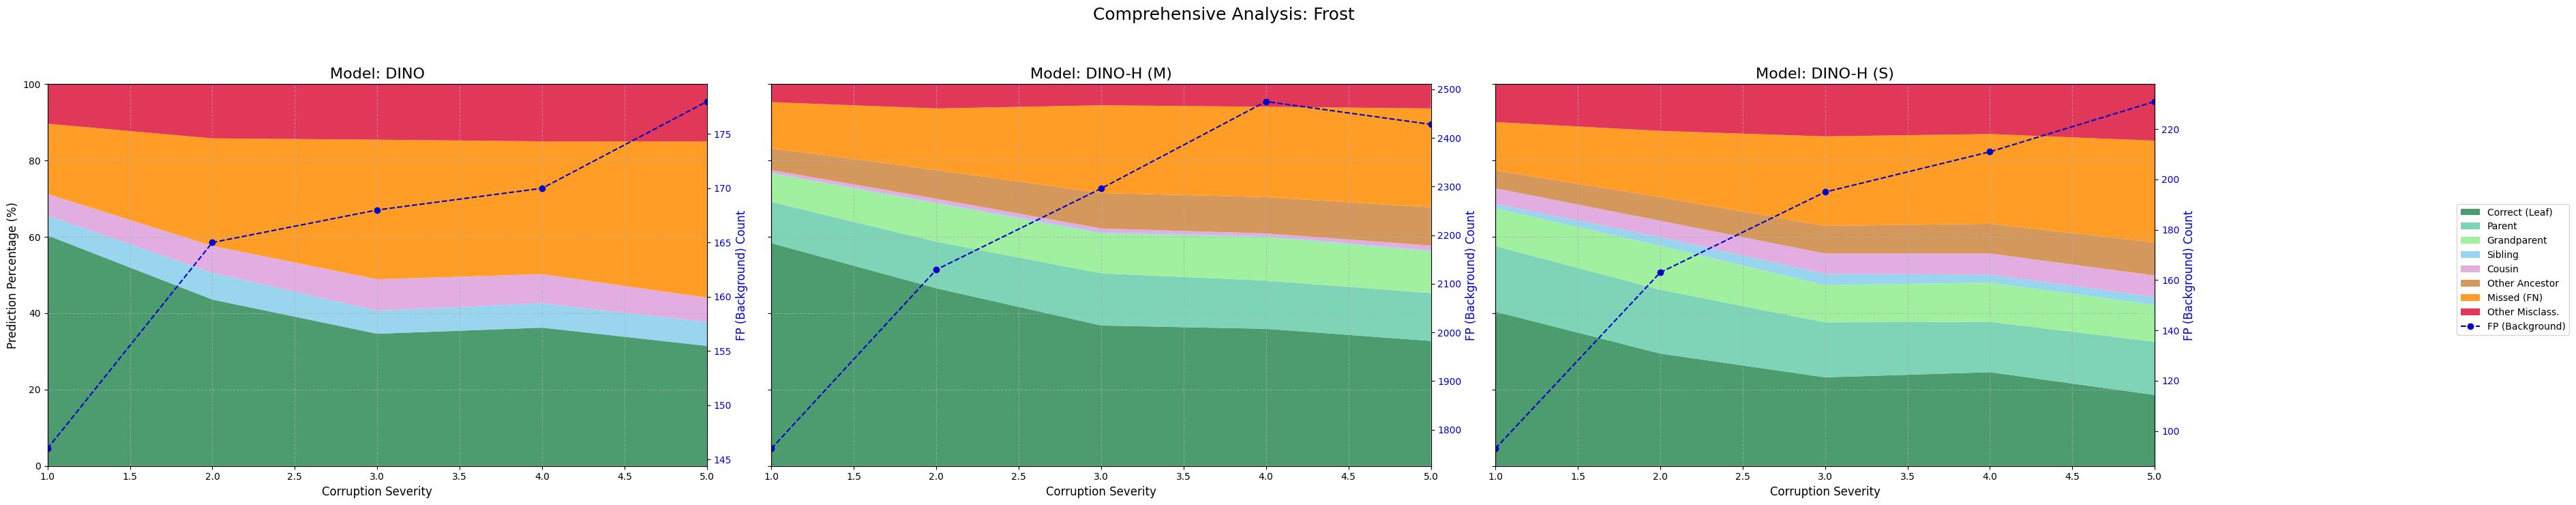

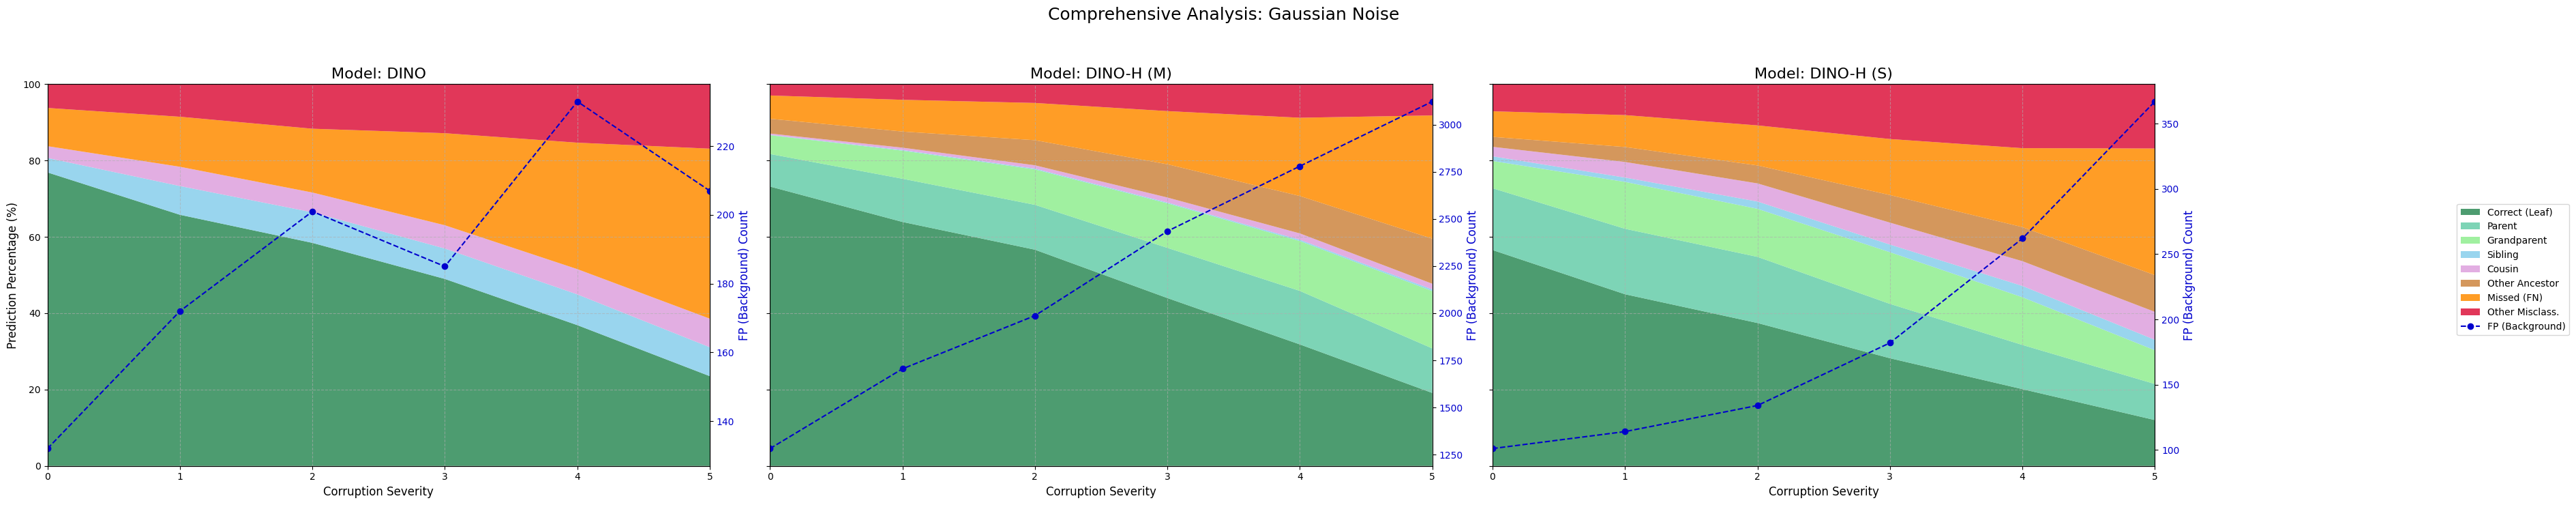

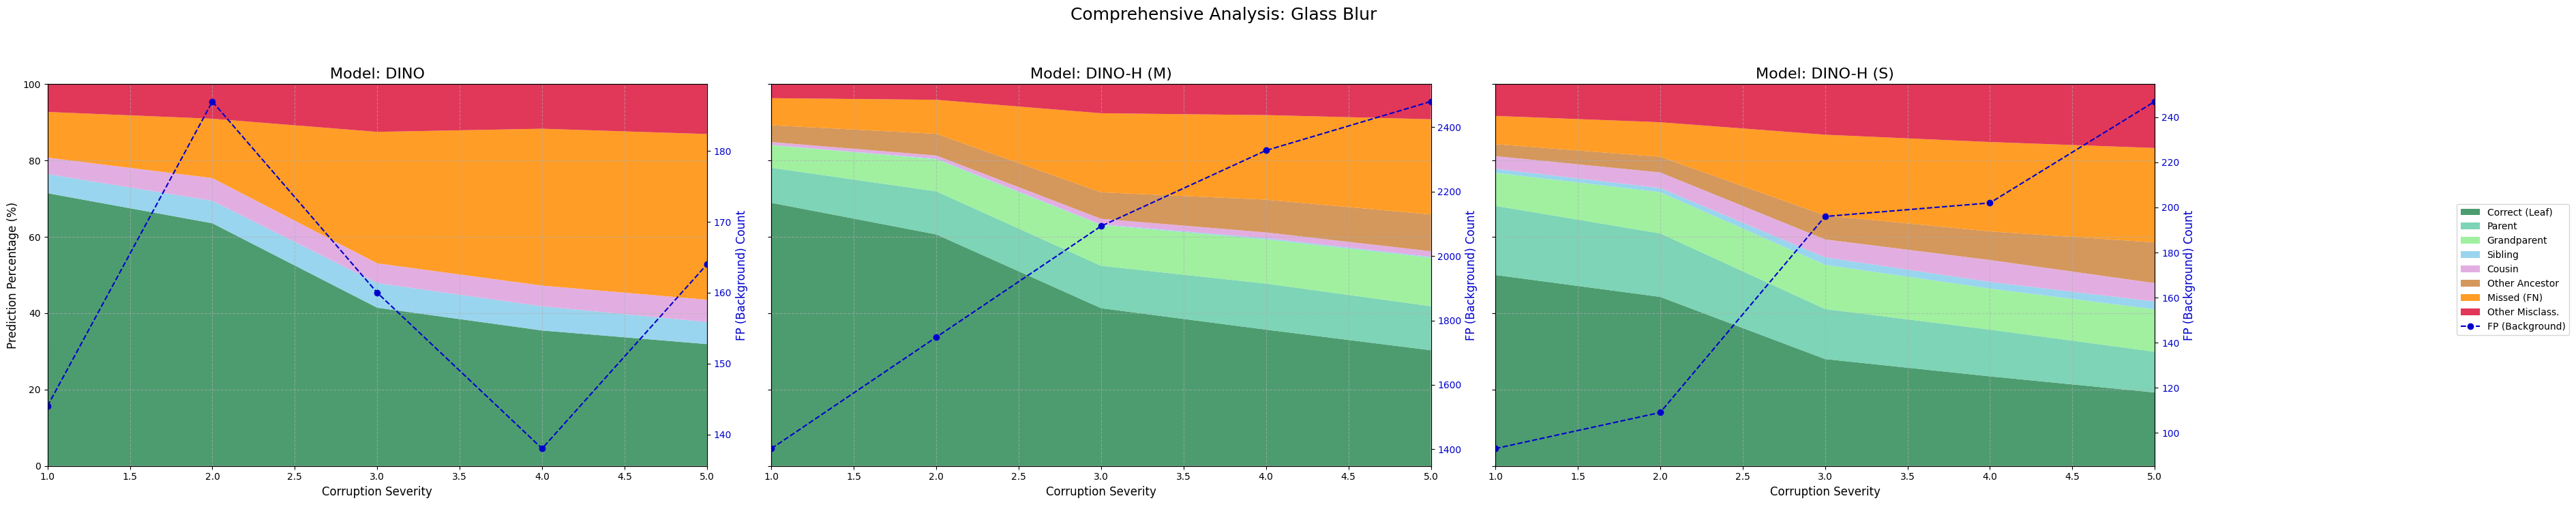

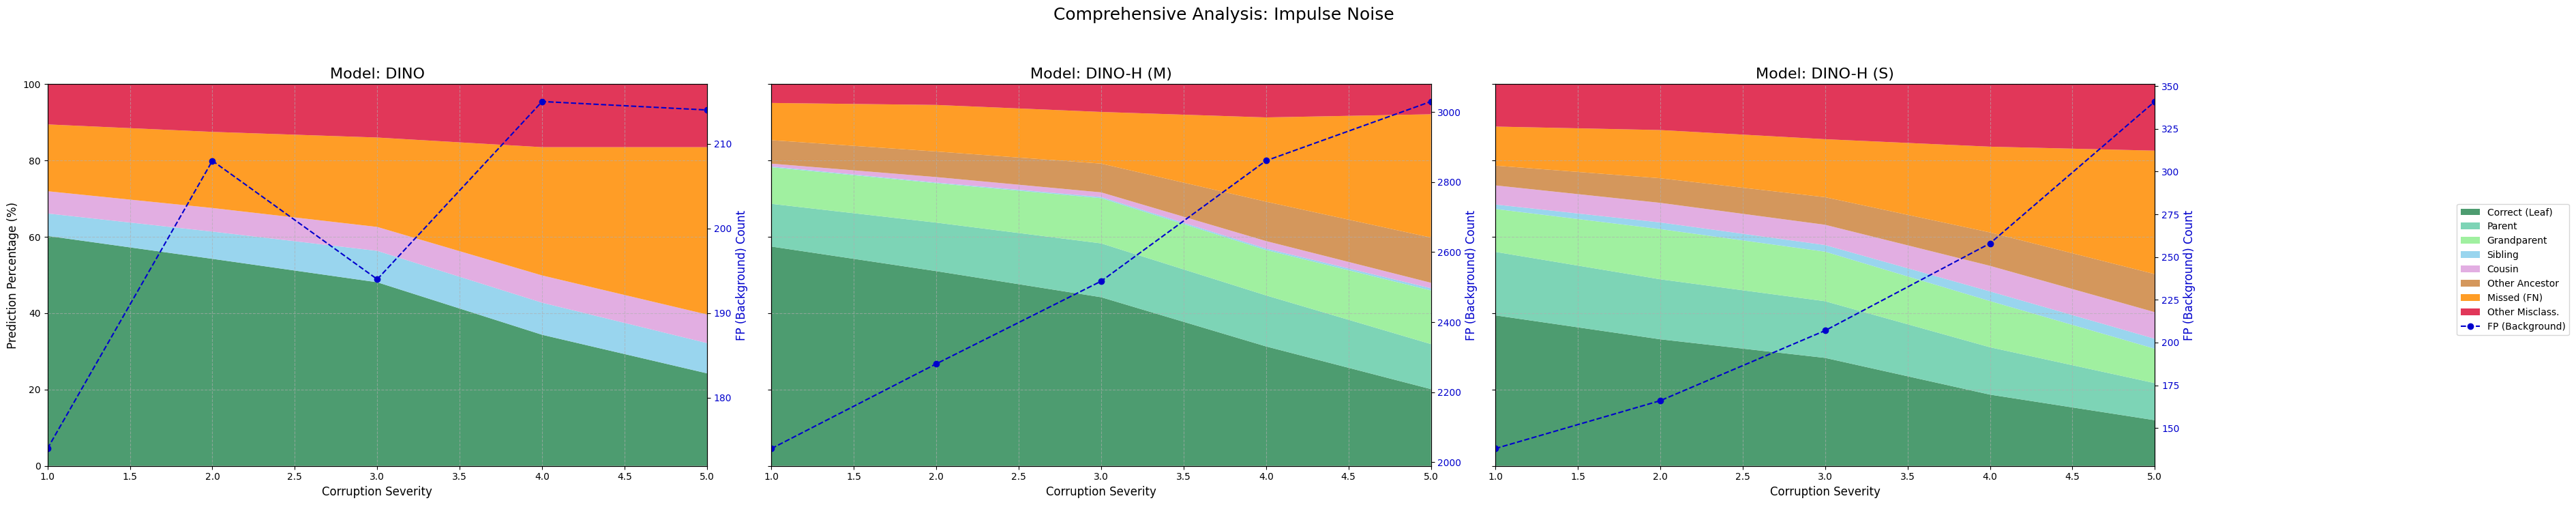

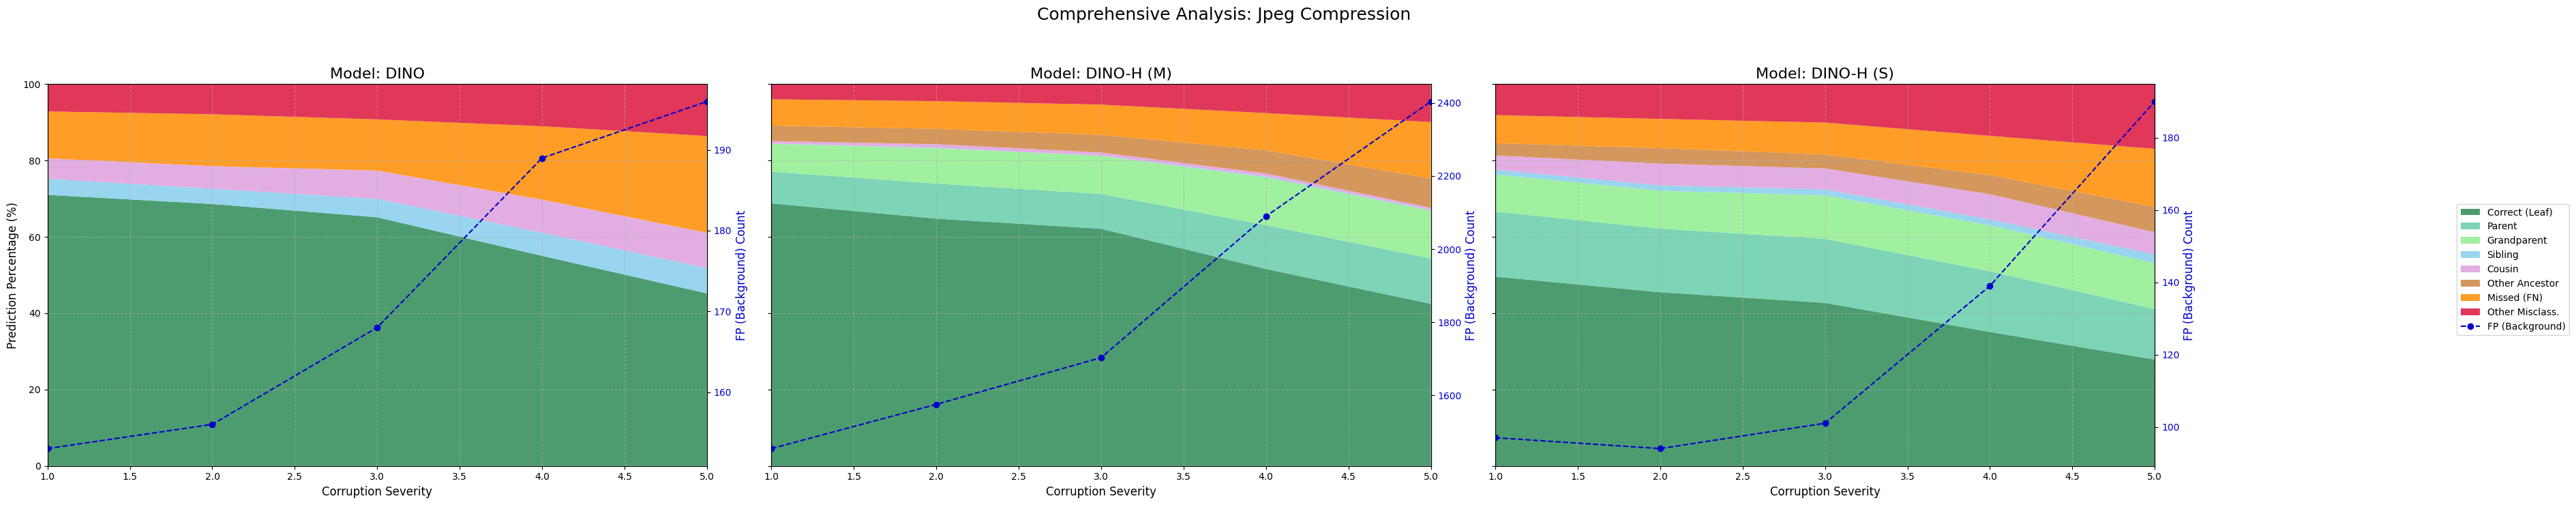

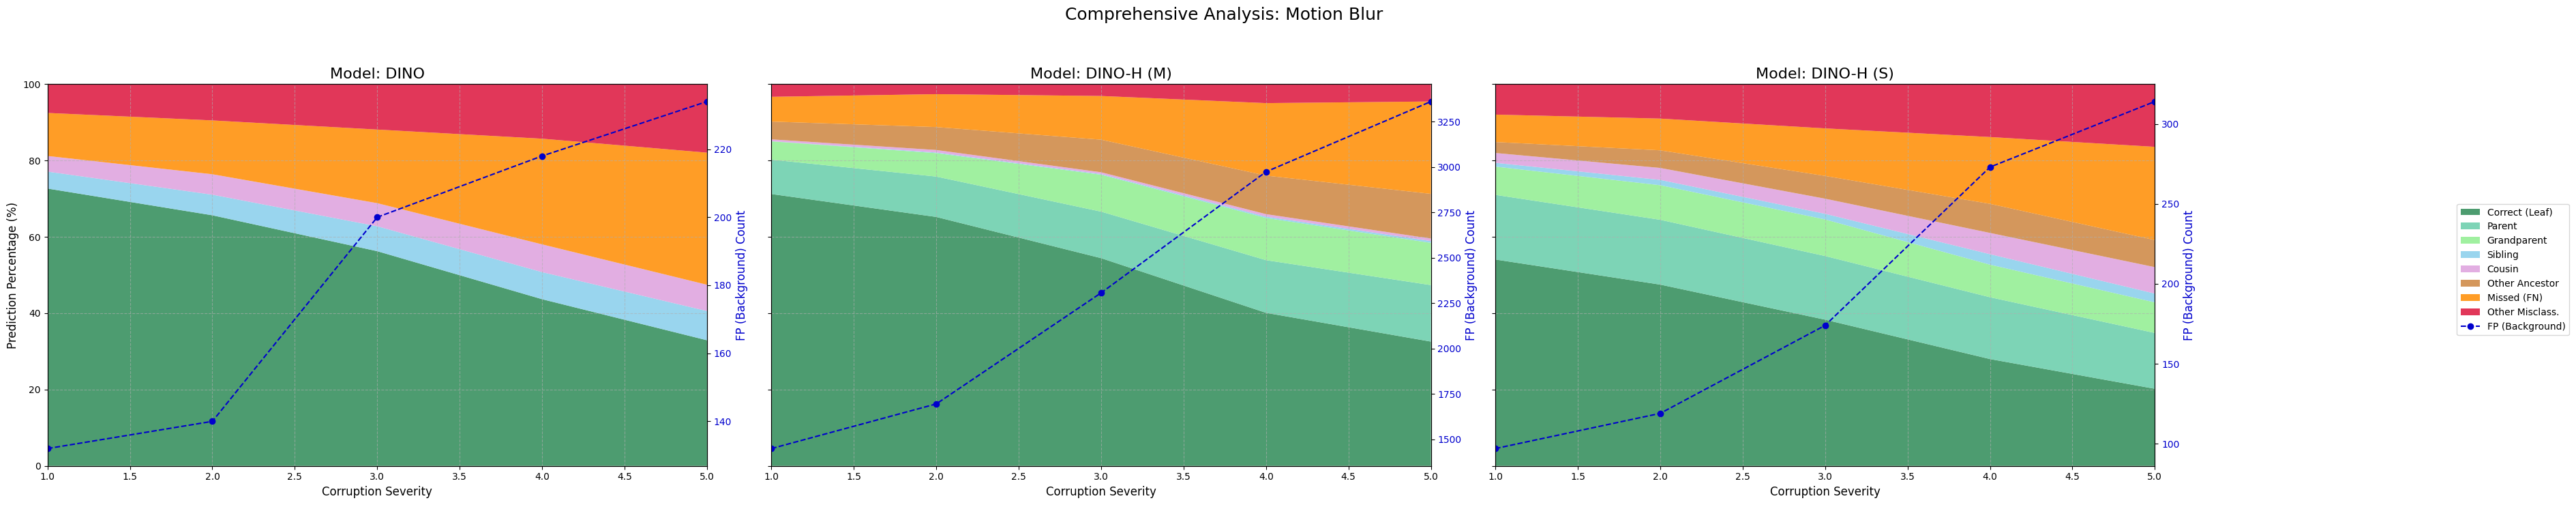

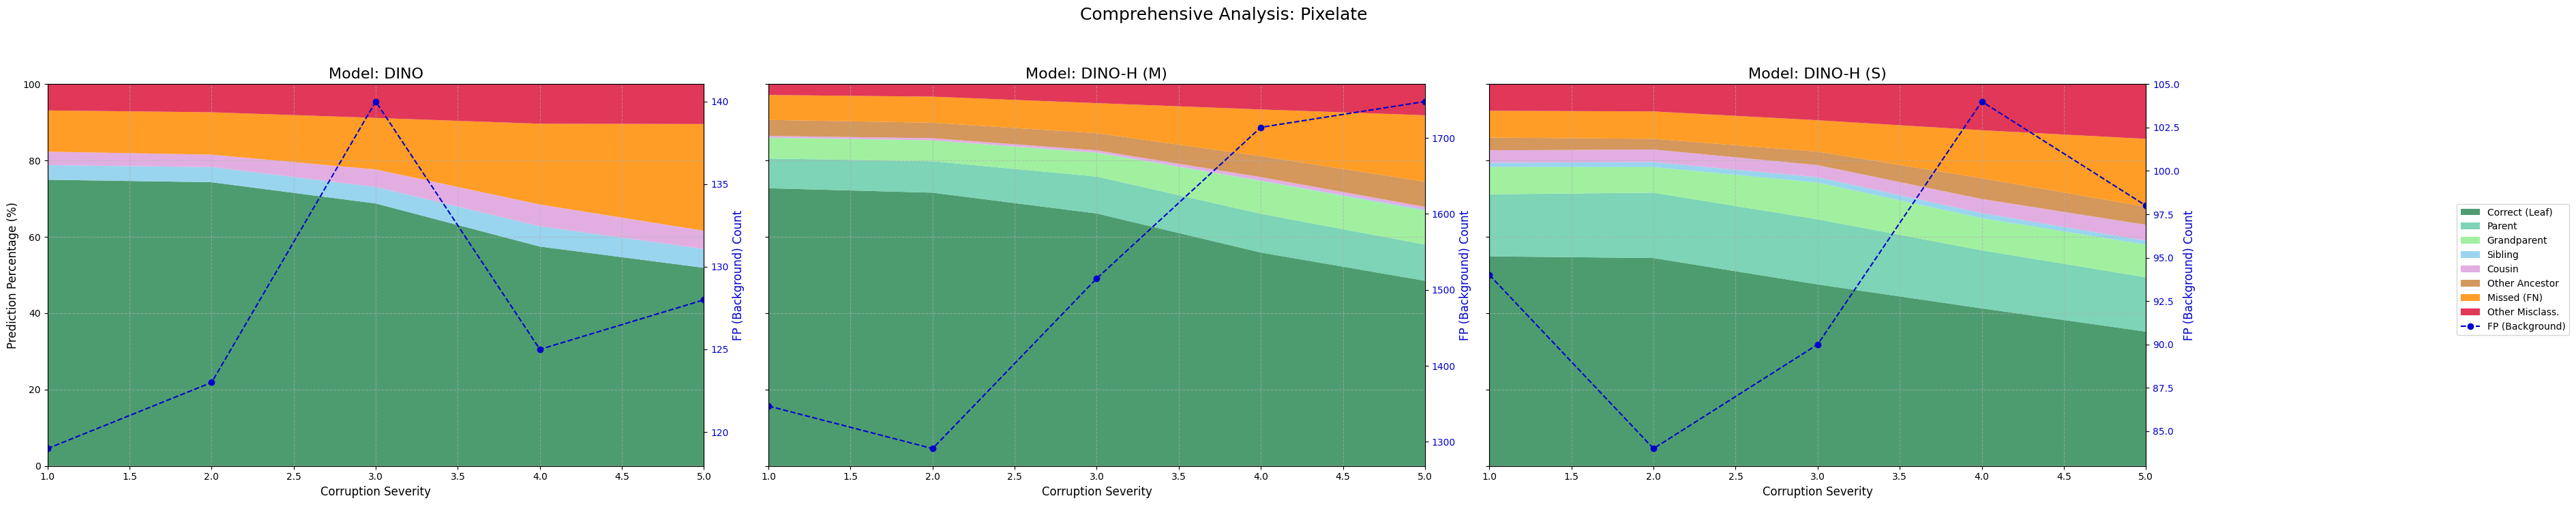

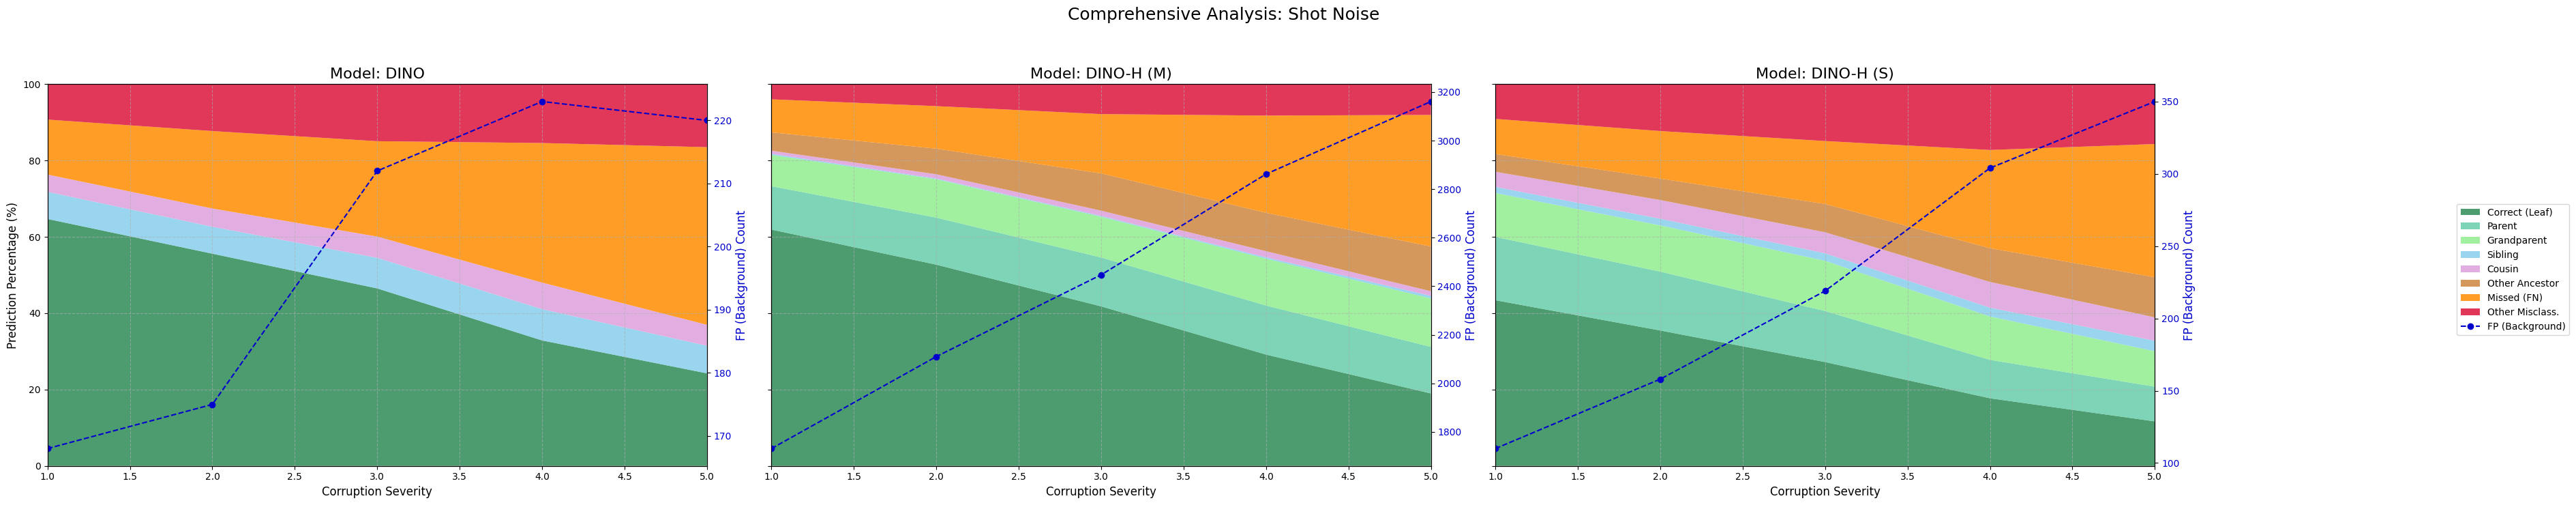

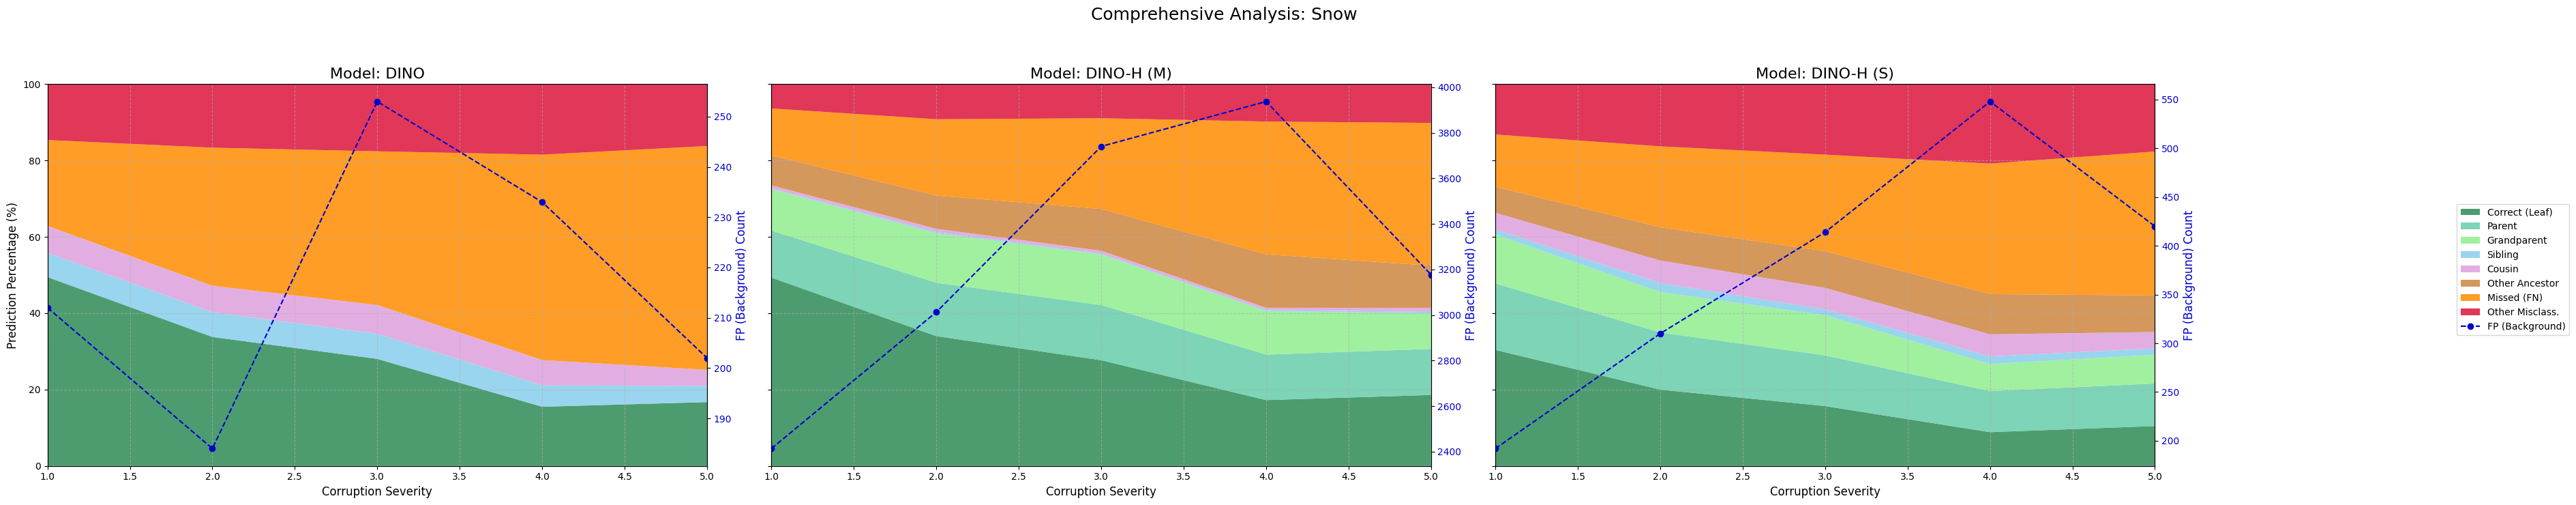

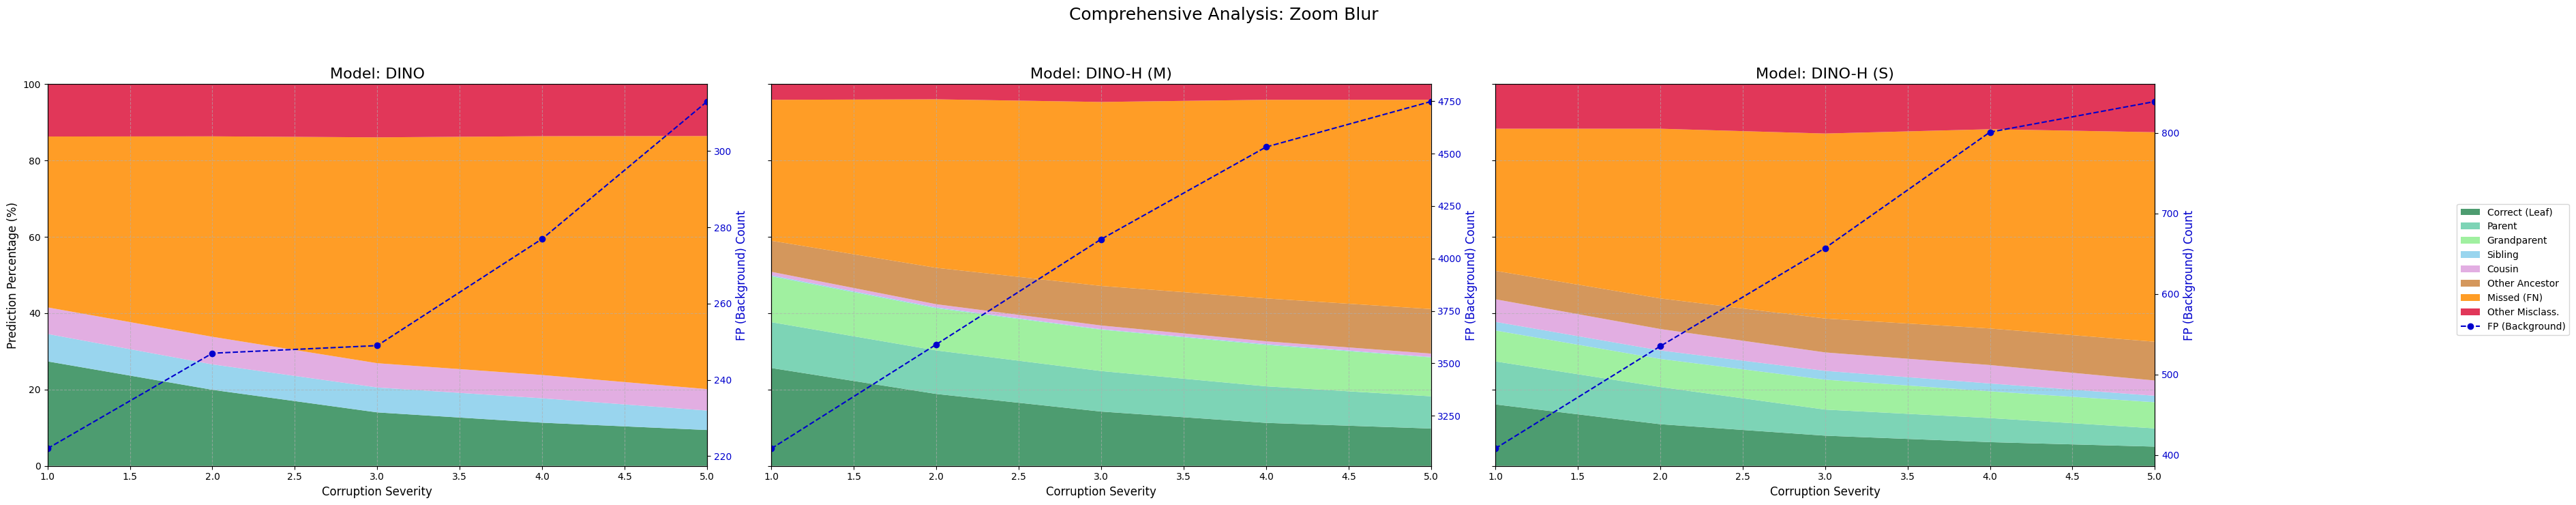

In [11]:
if not df.empty:
    corruption_types = sorted(df['corruption'].unique())
    model_names = df['model'].unique()
    num_models = len(model_names)

    # Generate a separate figure for each corruption type
    for corruption_name in corruption_types:
        fig, axes = plt.subplots(
            nrows=1, 
            ncols=num_models, 
            figsize=(12 * num_models, 7), # Increased width for legend
            sharey=True
        )
        if num_models == 1:
            axes = [axes] # Make it iterable

        fig.suptitle(f'Comprehensive Analysis: {corruption_name}', fontsize=18, y=1.05)

        for i, model_name in enumerate(model_names):
            ax = axes[i]
            # Filter data for the specific model and corruption
            plot_df = df[(df['model'] == model_name) & (df['corruption'] == corruption_name)].sort_values('severity')
            
            if plot_df.empty:
                ax.set_title(f'Model: {model_name}\n(No data)')
                continue

            # Prepare data for stackplot
            x = plot_df['severity'].values
            y_arrays = [plot_df[metric].values for metric in available_metrics]
            
            labels = [plot_labels[metric] for metric in available_metrics]
            colors = [plot_colors[metric] for metric in available_metrics]
            
            # --- Stacked Area Plot for Percentages ---
            ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
            
            ax.set_title(f'Model: {model_name}', fontsize=16)
            ax.set_xlabel('Corruption Severity', fontsize=12)
            ax.set_ylim(0, 100)
            ax.set_xlim(min(x), max(x))
            ax.grid(True, linestyle='--', alpha=0.6)

            # --- Line Plot for FP count on secondary axis ---
            ax2 = ax.twinx()
            fp_counts = plot_df['fp_bg'].values
            fp_label = plot_labels['fp_bg']
            fp_color = plot_colors['fp_bg']
            
            ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
            ax2.set_ylabel('FP (Background) Count', fontsize=12, color=fp_color)
            ax2.tick_params(axis='y', labelcolor=fp_color)

        # Common Y label
        axes[0].set_ylabel('Prediction Percentage (%)', fontsize=12)
        
        # Create a single shared legend for the figure
        lines, labels = axes[0].get_legend_handles_labels()
        # Get handles from the last created secondary axis
        ax2_handles, ax2_labels = fig.axes[-1].get_legend_handles_labels()
        fig.legend(lines + ax2_handles, labels + ax2_labels, loc='center right', bbox_to_anchor=(1.05, 0.5))

        # Adjust layout
        fig.tight_layout(rect=[0, 0, 0.9, 1])
        
        plt.show()
else:
    print("DataFrame is empty. Cannot generate plots.")


### Average Distance Analysis

This plot shows the average hierarchical distance between the ground truth and the miss-classified prediction. A lower distance indicates that the model is making "closer" mistakes (e.g., predicting a parent or sibling).

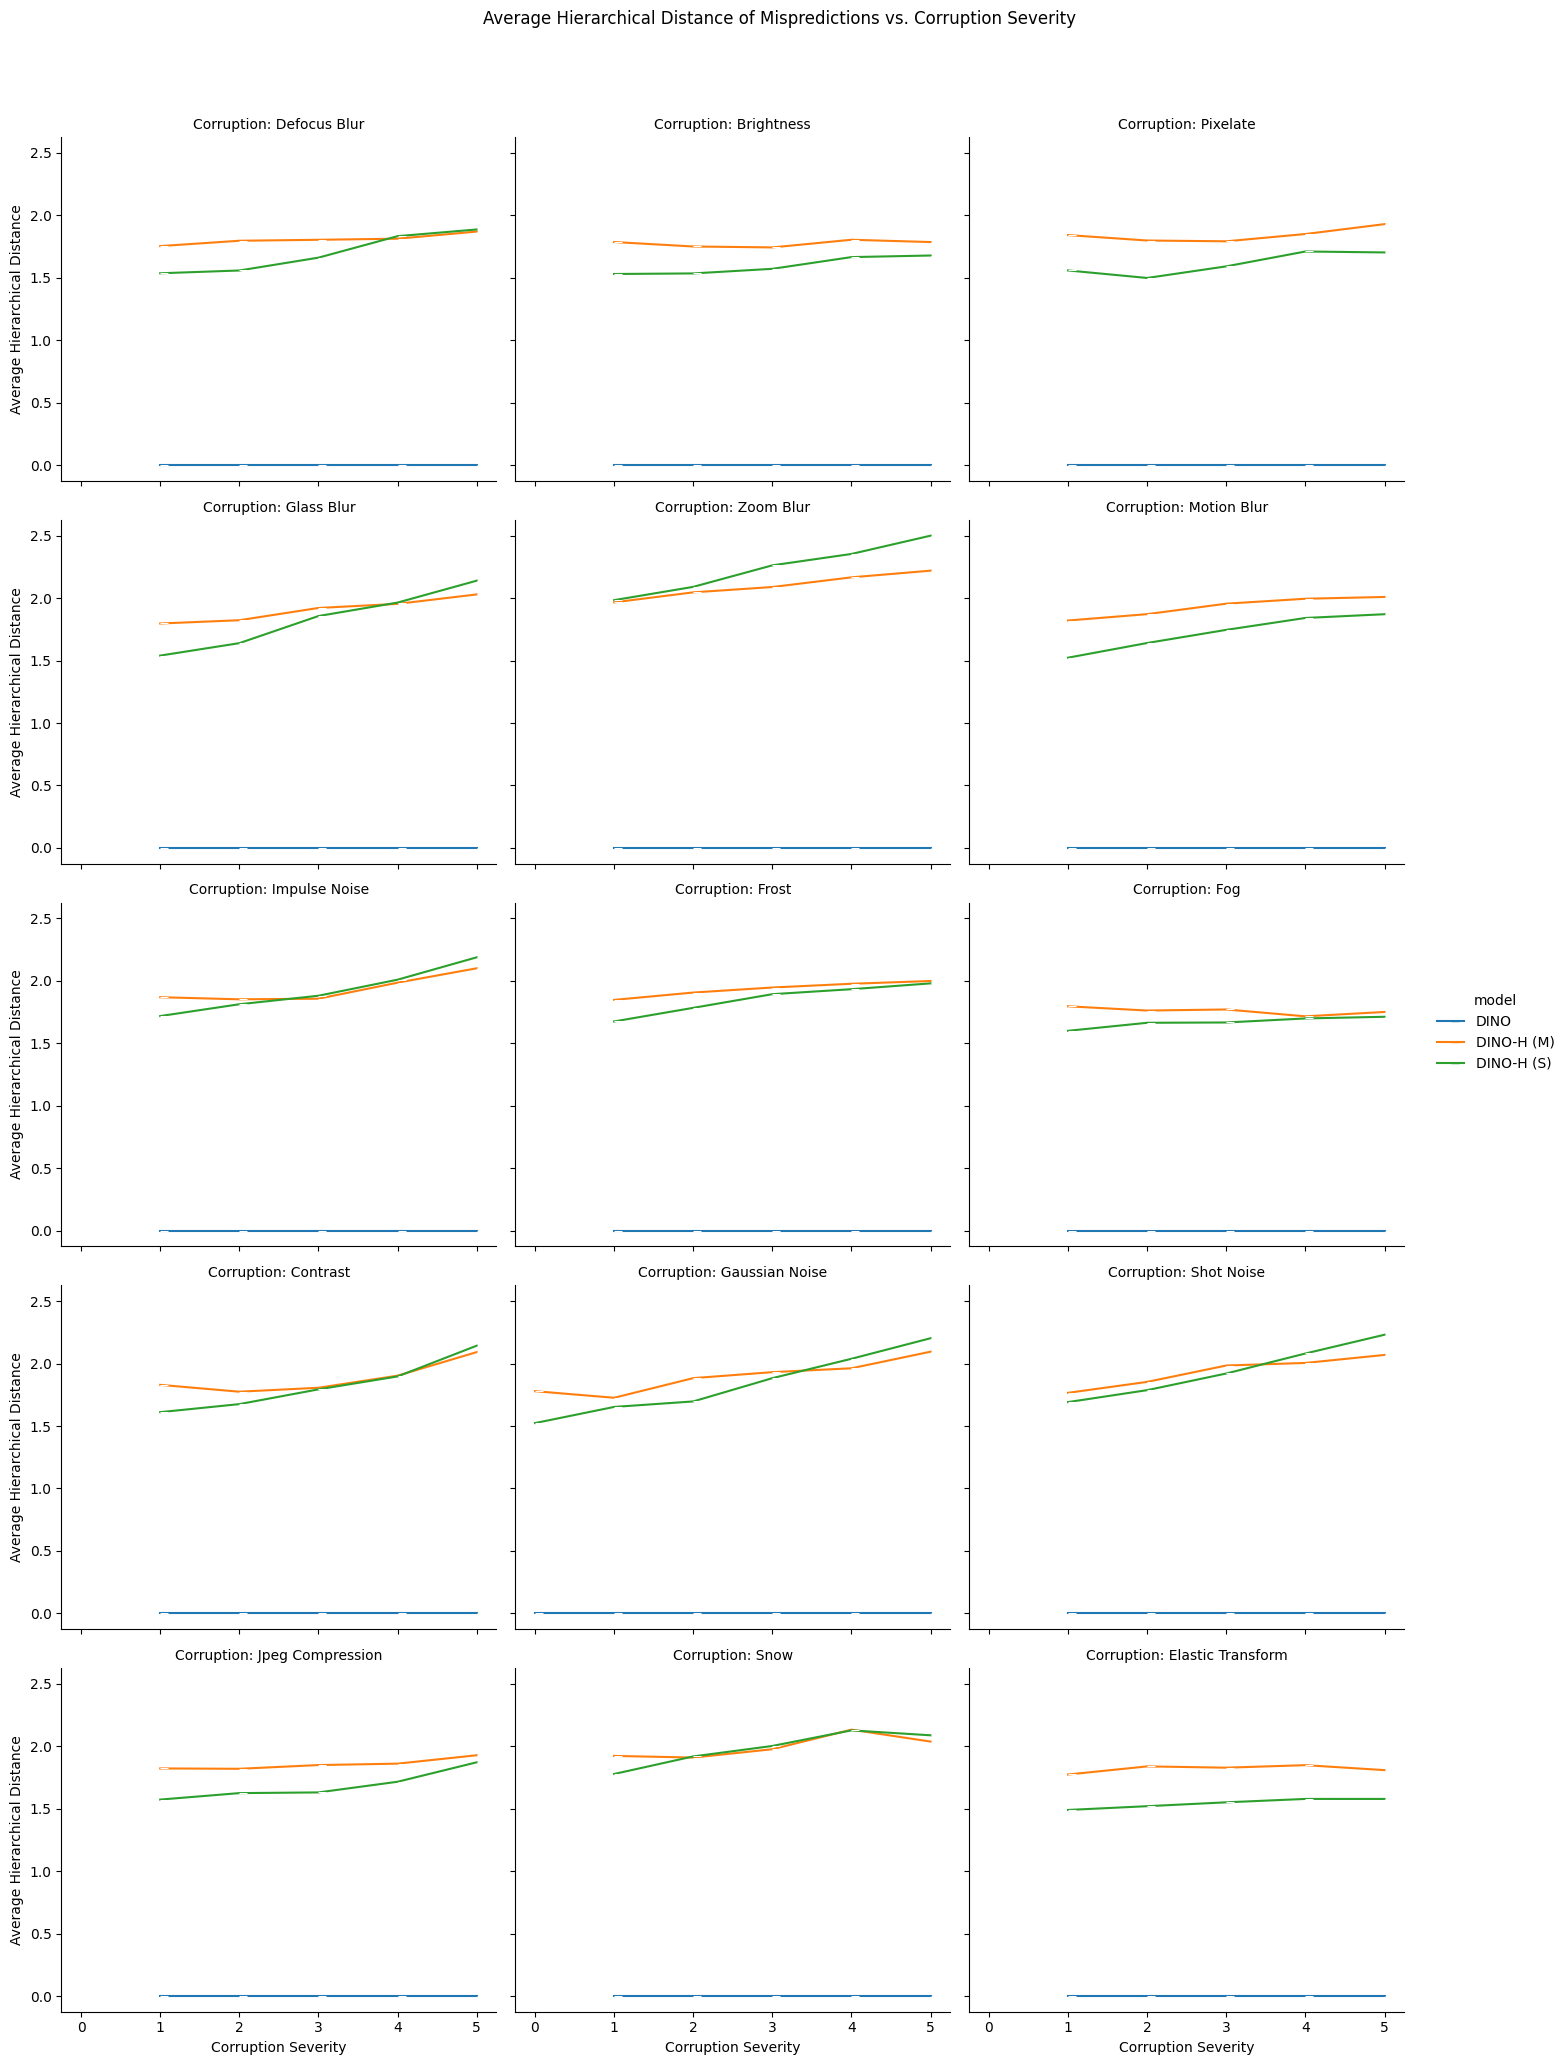

In [12]:
if not df.empty:
    # Create the faceted plot using Seaborn
    g = sns.relplot(
        data=df,
        x='severity',
        y='avg_distance',
        hue='model',
        col='corruption',
        kind='line',
        marker=True,
        col_wrap=3,
        height=4,
        aspect=1.2
    )
    
    g.fig.suptitle('Average Hierarchical Distance of Mispredictions vs. Corruption Severity', y=1.03)
    g.set_axis_labels("Corruption Severity", "Average Hierarchical Distance")
    g.set_titles("Corruption: {col_name}")
    g.tight_layout(w_pad=1)
    
    plt.show()
else:
    print("DataFrame is empty. Cannot generate plots.")